In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as opt
import scipy.integrate as integrate
import sys
import scipy.stats
from iminuit import Minuit
import scipy.constants as scon

MassPerPart = 2.60809383837199e-20 # solar masses

H = 1.8359e-18 # 1 / s
G = 6.672e-8 * (3.24078e-25)**3 * (1.989e-33)**(-1)
rhoc = 3 * H * H / (8 * np.pi * G) # M_sun / Mpc^3

"""
Functions used to load in the data and prepare the halos for analysis
""";
def load_data(PATH, time_step, num_files):
# loads in the data from the .particle and .ascii files and concatenates "num_files" of these files into arrays
# that can be read as the data from a single file
    for i in range(num_files):
        print('Loading File ' + str(i))
        if i == 0:
            particle_data=np.loadtxt(PATH + 'halos_' + str(time_step) + '.' +\
                                     str(i) + '.particles',
                                     dtype=float, delimiter=' ', comments=['#', '&'])
            ascii_data   =np.loadtxt(PATH + 'halos_' + str(time_step) + '.' + str(i) + '.ascii',
                                     dtype=float, delimiter=' ', comments='#')
        else:
            particle_data_new = np.loadtxt(PATH + 'halos_' + str(time_step) +\
                                           '.' + str(i) + '.particles',
                                           dtype=float, delimiter=' ', comments=['#', '&'])
            ascii_data_new    = np.loadtxt(PATH + 'halos_' + str(time_step) +\
                                           '.' + str(i) + '.ascii',
                                           dtype=float, delimiter=' ', comments='#')
            particle_data = np.concatenate((particle_data, particle_data_new), axis=0)
            ascii_data    = np.concatenate((ascii_data, ascii_data_new), axis=0)

    print("Data Loaded...")
    return particle_data, ascii_data;

"""
Functions used to calculate the halo density profile
""";
def parse_halos(ascii_data):
# gets the number of particles in each halo so that when you read in the particle data, you know when to start and
# stop when looking at particles for a specific halo
    halo_nums = ascii_data[:, 1]
    halo_breaks = np.empty(np.size(halo_nums) + 1)
    for i in range(np.size(halo_breaks)):
        halo_breaks[i] = np.sum(halo_nums[:i])
    return halo_breaks;

def get_halo_position(particle_positions):
# gets the position of the halo by finding the center of mass of the halo assuming each particle has the same mass
    x = np.mean(particle_positions[:, 0])
    y = np.mean(particle_positions[:, 1])
    z = np.mean(particle_positions[:, 2])
    return np.array([x, y, z]);
    
def get_separations(particle_positions, halo_position):
# gets the radial separations of each particle from the center. This will allow for a calculation of the 
# radial density profile
    separations = np.zeros(np.shape(particle_positions)[0])
    for i in range(np.shape(particle_positions)[0]):
        separations[i] = np.linalg.norm(particle_positions[i, :] - halo_position)
    return separations;

def get_density_profile(particle_data, ascii_data, halo_breaks, halo_id, N):
# finds the density profile of the halo with id "halo_id". The density profile is a histogram of particles with N
# bins of radial separation.
    # get data for the halo you chose
    break1 = int(halo_breaks[halo_id])
    break2 = int(halo_breaks[halo_id + 1])
    halo_particles = particle_data[break1:break2, 0:3]
    halo_position  = get_halo_position(halo_particles)
    displacements  = get_separations(halo_particles, halo_position)
    if len(displacements) == 0:
        return np.zeros(N), np.zeros(N), 0.0, 0.0, 0.0;
    radius = np.max(displacements)
    half_mass_radius = ascii_data[halo_id, 48]
    
    fractions = np.linspace(0.22, 1.0, N)
    radial_fractions = fractions * radius 
    # gives an array of 10%, 20%, ..., 90%, 100% of the halo radius
    radial_counts = np.zeros(N)
    for i in range(0, N):
        counts = 0
        for j in range(len(displacements)):
            if displacements[j] <= radial_fractions[i]:
                counts += 1
        radial_counts[i] = counts
    density = radial_counts * MassPerPart / (4 * np.pi * radial_fractions**3 / 3)
    std_density = np.sqrt(radial_counts) * MassPerPart / (4 * np.pi * radial_fractions**3 / 3)
    normalized_counts = radial_counts / len(displacements)
    
    return radial_fractions, density, radial_counts, radius, std_density;

def plot_density_profile(radial_fractions, density, radius, std_density):
# plots the density profile along with fits to the density profile to an nfw density profile
    ics_nfw = np.array([radius, np.mean(density)])
    popt_nfw, pcov_nfw = opt.curve_fit(model_nfw, radial_fractions,
                                       density, p0=ics_nfw, sigma=std_density)
    radial_fit = np.linspace(np.min(radial_fractions), np.max(radial_fractions), 1000)
    nfw_fit = model_nfw(radial_fit, popt_nfw[0], popt_nfw[1])
    
    params = {'legend.fontsize': 14,
              'legend.shadow': False}
    plt.rcParams.update(params)
    plt.figure(figsize=(10,7))
    plt.errorbar(radial_fractions, density, fmt='o', yerr=std_density, label='Simulation')
    plt.plot(radial_fit, nfw_fit, '-', label='NFW Fit')
    plt.xlabel('Radius (Mpc)', fontsize=16, fontname='serif')
    plt.ylabel(r'Density (M$_{\odot}$ / Mpc$^3$)', fontsize=16, fontname='serif')
    plt.title(r'Radial Density Profile',
              fontsize=16, fontname='serif')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()
    return;

"""
Functions used to fit halos to an NFW profile
""";
def get_mass(R, rs, rho_0):
# get the mass contained within a radius R of a halo w/ nfw profile and parameters rs and rho_0
    result = 4 * np.pi * rho_0 * rs**3 * (np.log((rs + R) / rs) - R / (rs + R))
    return result;

def get_largest_halos(ascii_data, num_sigma):
# finds all of the halos that have a total number of particles "num_sigma" standard deviations above the mean
# number of particles
    largest_halos = []
    for i in range(int(np.shape(ascii_data)[0])):
        if ascii_data[i, 1] >= np.mean(ascii_data[:, 1]) + num_sigma * np.std(ascii_data[:, 1]):
            largest_halos.append(i)
    return largest_halos;

def model_nfw(r, Rs, rho_0):
# the model equation for an nfw profile
    return rho_0 / ((r / Rs) * (1 + (r / Rs))**4);

def nfw_m_c(r, m200, c200, r200):
    t1 = m200
    t2 = 4 * np.pi * (np.log(1 + c200) - c200 / (1 + c200))
    t3 = r * (r200 / c200 + r)**2
    return t1 / (t2 * t3);

def log_poisson_error(log_rho_s, r_s, raw_radii, raw_densities, raw_counts):
# find the negative sum of the log liklihoods of observing the measured number of particles
# given a mean from the nfw profile with parameters rho_s and r_s
    # get the actual number of particles measured at each radius
    counts_obs = raw_counts
    # get the expected mass inside a radius from the nfw profile with parameters r_s and rho_s
    mass_exp = get_mass(raw_radii, r_s, np.exp(log_rho_s))
    # convert this expected mass into an expected number of particles
    counts_exp = mass_exp / MassPerPart
    #print(abs(counts_obs - counts_exp))
    log_liklihood = 0
    for i in range(np.size(raw_counts)):
        log_liklihood += scipy.stats.poisson.logpmf(int(counts_obs[i]), counts_exp[i])
        
    print(-1 * np.sum(log_liklihood))
    return -1 * np.sum(log_liklihood);

def fit_profile_to_nfw(raw_radii, raw_densities, raw_counts):
# supposed to fit to an nfw profile by minimizing the log liklihood. Not doing that currently
    initial_guess = (np.log(max(raw_densities)) / 10, max(raw_radii))
    bnds = ((0.1, None), (1.0e-15, None))
    result = opt.minimize(lambda params: log_poisson_error(params[0], params[1], raw_radii,
                                                            raw_densities, raw_counts), 
                         initial_guess, method='Nelder-Mead', bounds=bnds, options={'maxiter': 10000, 'fatol': 10})

    rho_s = np.exp(result.x[0])
    r_s = result.x[1]
    
    print(result.message)
    print(max(raw_densities), max(raw_radii))
    return rho_s, r_s;

"""
Functions used get M and c plot
""";
def get_halo_radius(particle_data, ascii_data, halo_breaks, halo_id):
    break1 = int(halo_breaks[halo_id])
    break2 = int(halo_breaks[halo_id + 1])
    halo_particles = particle_data[break1:break2, 0:3]
    halo_position = get_halo_position(halo_particles)
    separations = get_separations(halo_particles, halo_position)
    return max(separations);

def get_c(rs, r200):
    return r200 / rs;

In [3]:
PATH = '/scratch/bsafdi_root/bsafdi/wentmich/halos/'
#'/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/minicluster_20.08.19/output/'
N = 20
NSigma = 2
haloid = 250

params = {'legend.fontsize': 14,
          'legend.shadow': False}
plt.rcParams.update(params)
plt.figure(figsize=(10,7))

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

particle_data, ascii_data = load_data(PATH, 28, 1)
halo_breaks = parse_halos(ascii_data)

Loading File 0
Data Loaded...


<Figure size 720x504 with 0 Axes>

In [4]:
largest_halos = get_largest_halos(ascii_data, 5)
print(np.size(largest_halos))

75


2211589.2301459215
2198108.002918668
2205249.9935370507
2191768.7663097996
2181995.2077186164
2174669.3385180235
2159414.0908380346
2143437.4666660046
2116494.6420146073
2093432.182247273
2049152.68016221
2007052.9543974372
1932161.9706879745
1863785.2034158758
1737648.5596604862
1624156.6452452086
1415973.7837393335
1220697.67888892
867554.8199891718
556590.163102566
19784.985859466582
28056156.236827485
916501.0013653007
4091.9336797077162
28056156.23682748
2880594120.878643
407655.9279169332
12537336.43450163
182873.98820308782
593781.333704015
80026.91679270174
61903.41142612548
8337.639305276012
53732.90579783312
7008.6825669972395
18377.90267325172
4168.5703598082355
7596.649571905698
4751.864887172425
4817.200385869296
4156.52895424446
5485.691666991448
3959.8950504923573
3921.7336688740106
3973.2449682865395
4165.1056207886495
3970.756145368401
4004.618899721644
3944.1939128511394
3900.08547879071
3873.195321552086
3846.975499039153
3803.2645158035302
3745.9197287050692
3678.17

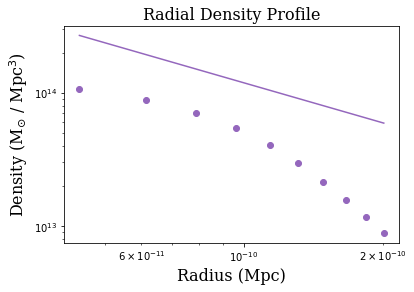

208154969285974.66 5.692600467120768e-11
3706801.3589441148
3683335.176967853
3695294.2000852176
3671828.0181089886
3654588.793684175
3642296.856312757
3615861.698067674
3587361.850738605
3540085.656005632
3500487.150557031
3423439.9690178744
3349147.862205505
3218125.2718138746
3099606.4869463965
2879761.625794103
2680779.6924274187
2317259.8568786336
1977515.896052504
1361905.6338298197
819036.5268450746
34068.00786691335
102730001.72380811
1446381.984452599
120335.76698240053
8049742899.760868
560864.0908844331
48808202.177427515
183946.08006866588
3252483.7503762227
45697.30098894058
98792.25462887925
48883.438689918745
36901.98619453187
280956.41718378686
22414.915517601545
23474.170822101576
47246.92792095675
22875.675360893903
23560.737085738052
22084.48954507364
28050.999101808724
21653.559605419796
22021.035412697034
23358.204327530737
21732.862955139695
21771.140239793072
21664.019088696274
21529.736017658444
21459.2449663823
21779.516747832655
21570.89864387948
21368.0222263

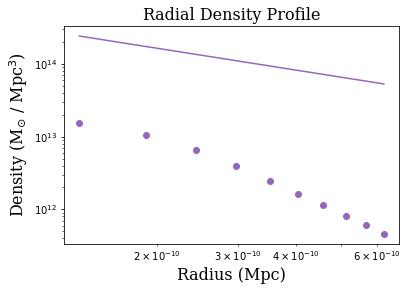

1419857416221426.5 2.3078730920265392e-11
7703168.607241695
7656038.466492025
7681411.399565827
7634281.258816163
7600306.41446043
7574302.721118683
7520868.717386842
7465603.771681967
7371732.587089016
7290643.783189343
7135819.364504919
6989495.003995016
6728231.455801822
6488768.857957431
6048034.978686947
5652447.49682661
4925561.623376603
4242749.299989803
3008888.6917709345
1923151.4202157184
60930.30996434365
116798305.19597505
3180557.126968353
19782.556550427445
116798305.19597508
12673367262.39607
1402493.835841678
51722691.09045994
617968.9673171549
2459810.167006081
261823.82733913322
284016.6432872778
118271.44881372477
48944.22008038142
250193.2016113098
24057.612223762615
56282.40703494202
24490.5556320466
32003.112118916077
20146.826434841718
31318.1220651423
20277.174947303145
23500.783914085296
19663.58153937153
19504.88724100958
19771.87315791159
20280.460843573564
19565.326186555765
19325.6606401232
19156.94035790826
19180.989820629904
18745.50491279601
18349.468498

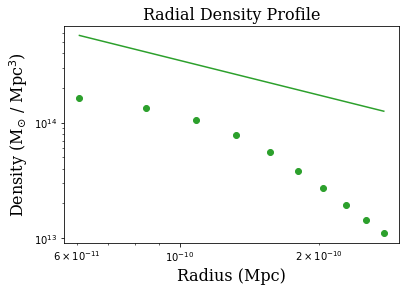

683925209371013.9 5.0801929730932e-11
1984585.3433934492
1972451.7667449394
1978531.185554351
1966397.6089058483
1957434.2170113344
1951179.257559888
1937536.7829630547
1922649.2289012703
1898122.5961335222
1877765.6601960112
1837933.3012058525
1799301.6262312175
1731415.042604617
1670237.9674761635
1556503.814671812
1453325.21103478
1265139.8970586157
1089500.7295928255
771016.0044325893
489903.8745019625
15037.477555368629
21070911.524222597
814568.9744384298
5698.308772042287
21070911.524222616
1656977270.7625582
355981.1226297044
9915870.604611846
154472.43580214362
553523.5803941572
64506.99284862042
69248.20198759095
29023.808257429497
13171.897409804376
60323.0470446145
6507.716524339025
14115.706634458087
7002.742415230914
8350.329475850947
5816.359036364235
8623.64924374724
5721.735517506051
5719.811048661177
5588.945724167975
5715.124080961782
6445.106638532125
5576.131080557957
5534.863377290525
5613.914363726337
5725.190148587574
5544.712506228588
5480.655329096468
5431.088

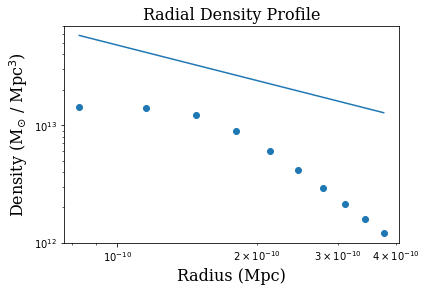

65040571999119.29 7.396686614143508e-11
2280093.0016611214
2265828.38195243
2273445.6306793825
2259181.0109706945
2248868.1318598907
2241058.3357444415
2224901.422119612
2208083.7622023923
2179622.388339579
2155151.6540872487
2108295.520594995
2063874.8265780222
1984711.841370655
1912301.4438389197
1778869.3137391564
1658949.1683559266
1438794.4622772553
1232153.3049465145
858586.5718938062
529771.5440679898
6939.548922277796
60272007.73199878
910448.425329696
28991.545785177215
6133680735.736857
372399.409192593
27165498.599419788
138391.01943536868
1499182.6258837066
41324.87457040013
245794.1835856933
11788.731969911578
38133.572919361744
9408.498248435955
26685.673668249205
7417.276037823507
11370.992090969412
7236.840780984834
9265.155814752387
6914.646264288843
7440.887422499295
6957.163129482768
7068.67688168324
6903.006665784863
6869.738374237861
6900.283116679424
6865.283520820893
6922.686607812013
6825.072480692049
6854.581283825509
6826.139256508484
6780.532651815902
6809.85

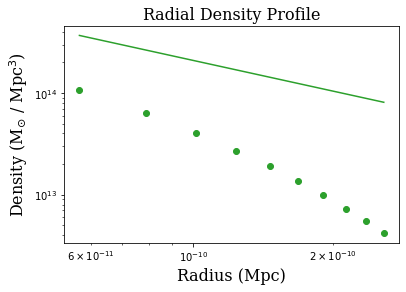

683488669851656.8 3.060209951620963e-11
1812988.1381443806
1801990.1077534694
1807481.9050220097
1796483.8746311034
1788350.4806628071
1782698.934898481
1770337.926255728
1756816.6005260868
1734570.7878396797
1716140.0597903978
1680036.5961368766
1644981.599814849
1583423.7607671581
1527990.586798099
1424889.9371800101
1331316.6071190964
1160705.2229407309
1001508.8639238799
712801.2876796816
457934.45135587355
19347.635939697604
15564267.02968057
752257.4178220388
4611.9177781986145
15564267.029680548
1237750340.9002802
336491.9250502985
7285749.130161257
153038.9448711322
378657.7784482789
69296.525373685
38060.659765201126
5347.346511060692
32337.04398257156
7931.246362713804
10363.868578596263
4788.783726985832
12072.903958333181
3839.2469264835836
3813.3718341399863
4375.594595909762
5430.456705238605
3945.09247706513
4302.757982071715
3813.9407332956266
3753.6416965409244
3732.3279952427074
3711.262520835583
3700.063315660773
3564.7948178661204
3549.2684016446774
3320.13227346120

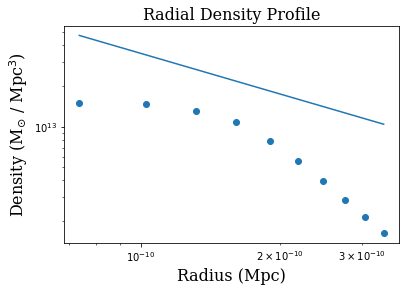

34739064945244.566 1.0040310833976027e-10
2077428.341778269
2064653.2257392688
2071154.1009368615
2058378.9848978675
2048989.477667264
2042306.7438434956
2027917.7601040888
2012388.686266235
1986644.5332600723
1965096.779475564
1923152.4188634832
1882689.8572914866
1811351.179367156
1746835.7568259377
1627147.0163961088
1518805.534209893
1320898.9537861105
1135940.6680847364
800796.8303480713
505173.7965591205
12123.304548703243
27366957.866474647
846791.2932347328
8237.149292426737
27366957.86647439
2264701863.0736957
364191.3735160375
12779819.25774189
152664.21908321054
722908.7374706822
59692.1879937259
99982.65564406288
24663.743244606027
22069.80210134822
8952.735175430715
43294.69768437438
6873.54978391412
7042.279196083928
12488.951044790581
6607.753163531029
6864.019655877755
8588.281934849534
6567.683217710952
6551.021435208949
6862.0866074449195
6946.813218948828
6519.184121813384
6444.988125350919
6388.30441218843
6418.155915980499
6236.267769806227
6146.405441876441
6477.9

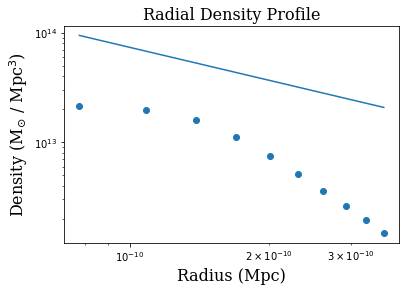

132559562056595.64 5.556927259103602e-11
15668883.940437127
15571579.358979957
15624376.697117614
15527072.115660455
15457123.969877362
15403038.053356506
15292614.566641504
15179113.42210227
14985630.43002884
14817748.102101399
14498074.257478528
14196833.960820312
13657979.201590378
13163172.753429228
12253471.793350369
11437889.311643835
9938028.189464595
8528177.54541007
5981420.89197579
3741184.3322431426
74640.59354964302
371130148.2890302
6336337.995508299
144419.08310620842
39977363654.16255
2667044.1513762996
165263330.08593354
1062250.9578760827
8641120.454735093
373029.84844115184
1318548.9968020143
137514.82079372267
349799.4236057539
68100.89007215557
134030.7753006303
79717.05823554244
89518.62289457895
69105.23345012646
95280.90186235792
67954.1608419572
67708.22235751251
70632.46662414211
74805.81335957852
67004.9285267847
66425.9007867295
65972.95829523278
67880.2454528308
66786.48678623578
65618.48219109494
65035.350543085304
63916.72957141864
62335.123834031816
61944

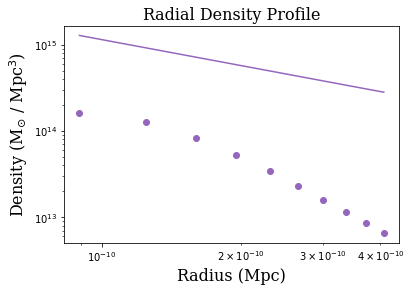

3982598011734064.0 2.869635578073423e-11
3408869.8333593006
3387387.6661622426
3398397.5304549495
3376915.363257914
3361163.3757213876
3349850.463188912
3325634.745286958
3299634.873979741
3256405.211664713
3220083.343715603
3149546.6411981075
3081667.9244191726
2961809.442562231
2853245.797640848
2652025.4061976788
2470052.896650013
2137415.6652051075
1826375.1180561436
1262929.7190788991
766147.0612736312
23623.23062521898
86750266.8751862
1340356.3052274238
85159.77996990182
7013531579.375521
529613.7676362824
40936315.16083686
182128.4529648778
2641846.7078158665
48974.91706899606
101592.40344747601
25284.696673839262
209740.13686292735
21858.55919855776
23418.124751262607
50577.50902474713
18521.523361758726
18416.728430243253
21138.201341110864
24432.149882408157
19118.059758115196
20107.75274658968
18505.287136681767
18142.581564380296
17939.437633405374
18224.294102680367
17440.54264754342
16918.704924126465
17592.317405651986
17275.439874525357
16054.01797280095
15734.75491709

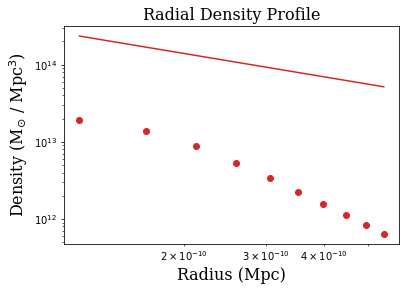

1108765265821681.1 2.518467582556256e-11
4797150.437800564
4767610.900362343
4783179.981243474
4753640.443805261
4732186.405440616
4716212.4165894035
4682805.882139072
4647681.239379932
4588580.5532054035
4538140.132359121
4441121.423188569
4348701.049777286
4184488.059154243
4034750.507071824
3758315.6305197584
3509385.559316833
3053018.0537292804
2625166.4859592402
1851207.485938882
1169532.4732974744
26515.457216919465
77444459.73585418
1958322.6416965723
19000.80602608702
77444459.73585556
7490734898.153771
843393.0590646485
35120628.02183775
353802.2065250296
1846475.3352172384
137333.29272229807
249517.8444221106
55523.68755273621
53966.568777029155
20744.848610141813
108199.11871956903
14663.40394387894
14957.503779170194
27307.121262060646
14469.14022489989
15146.68558049786
14304.410776411667
14612.12002818357
14177.257119212862
14476.128645273262
14118.441073719483
15648.334788459191
14024.334556884856
14114.202224259509
14406.46199465152
14040.701087509537
14034.59287556687


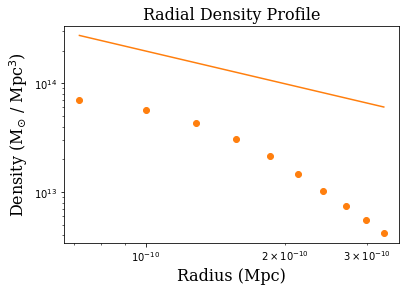

393540764671062.8 5.022808212220648e-11
24800731.78847117
24643118.516257405
24725168.642021026
24567555.3698074
24452591.937288467
24368355.83871147
24190366.477016147
24001458.700484138
23685293.928994093
23417346.546699874
22899747.752819166
22404419.250431847
21526774.01198407
20728928.05242578
19253337.111604095
17921948.942218825
15484339.358506659
13201837.633487206
9070190.733394556
5429999.104645452
258915.34113018966
849387955.3197745
9640051.068508528
956118.7066344359
73267044014.77213
3695566.56861338
396347201.8672937
1168726.2009701885
25334194.641053233
262374.8488941779
605744.3827685838
282920.49904944823
284641.64864716644
180233.715708578
441199.27404384286
159872.92188770266
521446.4701354924
137115.04742639154
147713.65937179682
283661.1463942671
134133.16790042605
142097.42224586202
134714.55813029362
152557.94127929484
132973.57014572347
132647.11418704118
133983.78948819434
137091.90581139724
132795.9644952346
132345.99407666858
132413.05421061287
132323.272651

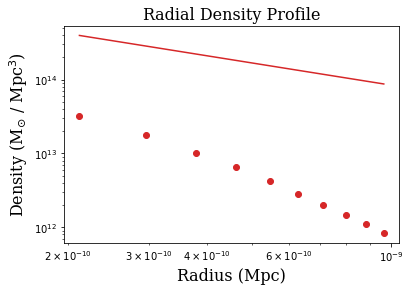

2261592077617729.0 3.7205419780298205e-11
4739677.312266401
4710712.244723586
4723949.737590195
4694984.6700474825
4672977.565005724
4659283.695495335
4627037.740540652
4589641.030267818
4530079.452437549
4482944.95371872
4387933.63844061
4293009.87776991
4129196.6718475195
3984482.4856580105
3712225.26449822
3462172.265471382
3010001.6837118925
2591137.5156670697
1828542.8230025277
1153088.4886647363
29658.698903293014
35774223.84643126
1930719.483268052
9111.977215499384
35774223.84643126
2093501929.6837053
833792.718157618
17788324.9440338
354090.03012979234
1138174.2674583946
143368.12432808685
146926.43031221692
61720.24533777029
25719.623004900164
125680.34188987954
10831.866680990663
28127.575698351284
12037.484393375835
15066.340331595367
9382.752862738766
15388.539991514841
9151.61251342826
9193.635717445533
8979.761959308782
9186.006019339035
8965.439379427367
9734.323376975852
8924.000457018563
8998.490820947525
8936.25095305698
8902.750268473083
8937.173171521019
9044.23543

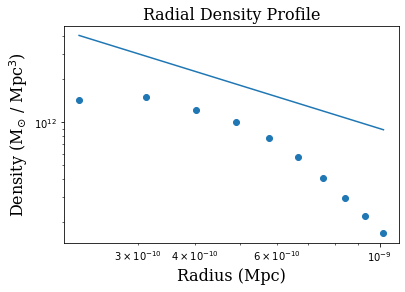

2484938074777.8447 3.6377490395160395e-10
1862913.0315119727
1851048.368668532
1856760.8235094699
1844896.1606660855
1836020.0771160806
1830129.5569420564
1816847.8947165438
1801951.4685236476
1777783.0435571931
1758144.7497614517
1719209.033112477
1680937.9536058633
1614231.713422721
1554655.6874174909
1443303.1734069074
1341713.8011509972
1157144.876018609
985477.905641857
673616.5514997215
398047.2118694253
20023.687974209683
45434959.373841085
715857.0665148232
72235.58312439408
2921864112.543878
267834.13051786425
22438383.485271797
79899.02754630169
1681132.3578102181
15871.534576536666
39097.91953110278
17091.489348821728
64409.88900849138
8427.149027774121
8366.817066411844
12513.087806059384
20950.57948599412
10184.501305809246
11528.552842714722
8739.265414540725
9263.453710022379
8417.811602018031
8230.718601493016
8129.934143126782
8218.58201465241
7854.875574495925
7644.579702368238
8112.316610499641
8346.170876855336
7944.327861692189
7870.280622813243
7543.034162217436
7

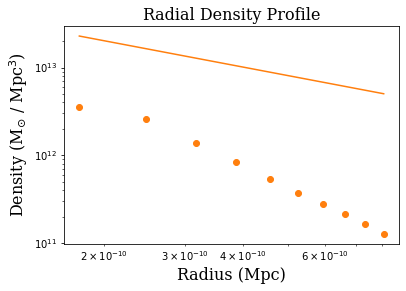

71450102185393.44 5.662051944759008e-11
2075768.6534635322
2063010.0014074412
2068846.6400385392
2056087.9879824966
2046396.9356234712
2040359.4578639697
2026154.1820009141
2009689.8481478011
1983458.426634951
1962689.9157535536
1920838.60199923
1879038.2254287463
1806888.9098420814
1743138.7151516648
1623217.0792495483
1513089.4709121967
1313928.9977551184
1129424.048540733
793524.6248309544
496033.9437813538
8136.769022415207
18021023.83060152
838540.3426517927
4077.3079741504002
18021023.830601454
1060839651.5119798
355444.35272807116
8967627.38396717
144884.09443478668
592102.0307969386
53974.136969294246
83471.00822833093
20274.28781905974
16167.37357147562
4740.391364422427
33883.71667141916
3144.6176828239077
3392.1216725502013
8554.089440802685
2795.6878953146092
2993.4133744588207
4399.353644578208
2806.470505264275
2863.125399577666
2777.673654461936
2746.2864479208843
2784.5982248084865
2751.4040277047825
2695.529423667691
2716.567502385165
2946.8489507901177
2704.8034126981

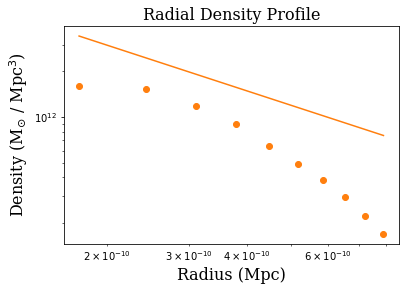

1893587134774.4905 3.150118304551578e-10
3911149.040268591
3885911.1022841427
3899157.2168037565
3873919.2788193426
3855561.759577657
3841969.389653435
3813441.535227887
3783348.60745102
3732806.288431363
3689779.74739673
3606892.5271381903
3527800.6495615267
3387408.0179661564
3259546.150142313
3023326.6112006907
2810428.6150350156
2420320.4789034734
2054803.3435721786
1393388.567582984
810976.1022787363
126573.3116818874
208396291.65061545
1484755.487477559
353050.26664649963
17684081634.96012
534099.611532902
97761168.41651472
142802.86941408596
221521.61350648128
109436.82455628137
210546.37289086398
72822.85470036129
339004.01341748645
35318.161132250425
45808.74627867986
177362.3208057156
41963.061566046206
64949.220598679014
35812.705587617646
47818.93229080281
36612.524203911256
38743.071252855545
35406.98923645007
37418.15143987324
35243.35457438642
35498.499991689896
35264.33713770547
35178.59772287012
35252.72829542917
35581.554576836235
35185.99378120444
35126.67653370291
3

260.2654200669931
263.2896492895852
259.09531360087203
258.37528651645516
261.55939252715507
259.59794972401505
260.5188408675949
259.2564138095295
258.2648327813313
259.2314523747318
257.5051211663613
258.7950289623386
259.3086682727626
257.9576542755076
257.1632555802262
256.7447976889107
257.4532121619959
256.82598065606726
256.32243242191
257.1587483509811
257.7916371080446
256.2443339714646
255.73749632948238
255.72533074694184
257.68885480415884
255.93342691409634
255.27828169307395
255.35942938214794
257.73928420996526
255.56972639278501
255.35336237663614
254.96032777438813
254.7502976808173
255.66880162566304
255.10498853227546
254.65271004388524
254.51237556982778
254.1122840892367
254.06688135603144
253.50441771065198
253.28971618892683
262.04066300964587
253.84284531645244
253.34953112396397
253.1350906414209
257.1684349944935
256.7799446851004
252.9516249234166
252.52294948894087
252.29440268129656
252.94452775246828
251.8600451009297
251.86243436466611
254.34986084102275


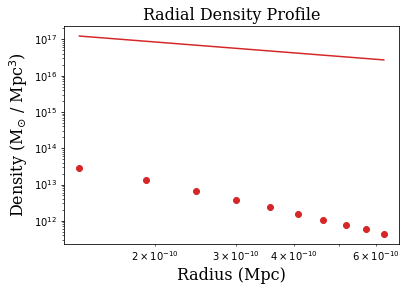

2.7674811806070407e+19 6.116162299103308e-13
2327966.928071519
2313516.5634879274
2321672.9071947425
2307222.542611151
2296985.7455481454
2288647.240642518
2272169.1600973965
2255773.239945654
2227290.3319405178
2201996.928918737
2154504.512349374
2110437.670423044
2030849.2544925103
1957038.4830553546
1822128.5511893542
1701938.6075188147
1479929.5101678804
1270453.4069437392
892820.0553125053
561235.0187009226
11750.421949524352
69745070.93254659
945974.0216285718
21024.022770377658
9285506945.357758
401623.97344595264
29817079.93768114
162727.9537507006
1393612.553564482
58559.836598623006
201645.37540036015
22006.62540127268
52531.52621527091
12086.045254581955
35476.38508320984
10917.354005260553
11404.380485311032
21856.249780276386
10266.702722684167
10243.835203691637
11080.149095665618
11907.842897736951
10265.760545894234
10065.379884885602
10001.964950077698
10089.258759795146
9714.087691563873
9509.815517849369
10364.082765933243
9822.118717913723
9317.329453376631
9171.207

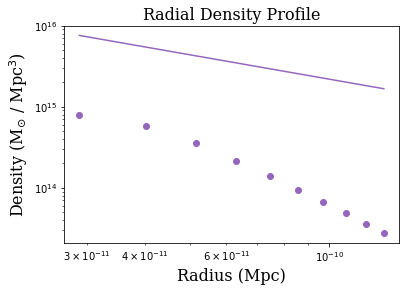

3.007769918313223e+16 7.288206630638348e-12
2767918.2551615336
2750642.569284433
2759950.5855705286
2742674.8996934304
2730224.716010035
2720685.9723114613
2701097.6837017885
2680850.6939493064
2646447.1642149533
2616716.1796198455
2559964.4342336133
2506342.4123560353
2410582.7259390005
2322801.717762056
2161252.5885438025
2016260.354769907
1749821.9686382788
1499534.9905214987
1047260.6965517834
649311.508316347
10461.506192303998
72159879.46600711
1110183.1795468172
32924.602642094884
7569116007.113136
458675.5752889335
32325169.36976102
174770.48361941514
1745332.5102799349
55632.38270602177
280488.41221962933
17953.514400261396
51712.640985824124
12195.772341339336
30390.42045232755
11665.784399983344
17401.130071536412
10400.06118956119
12100.081718854295
10655.604727559585
10811.778741110811
10411.724071612978
10315.275573466239
10445.177174249076
10982.267612344345
10302.486660775343
10237.122038054236
10239.343753207391
10387.494044860674
10271.838898252041
10196.251537069882


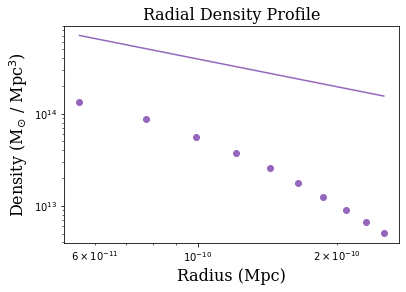

1764795226261012.0 2.2167765862423497e-11
19998688.93176987
19870821.40918387
19942407.77676415
19814540.25417817
19723673.30874223
19650462.506708544
19504799.784340523
19358854.636360765
19106337.861700144
18883212.43938282
18462999.765553083
18071778.38666875
17366657.431480926
16714180.075094054
15520027.119095583
14454584.427979006
12488488.683849147
10635122.06629015
7292245.380554708
4356180.473040642
426263.70742162486
1300021664.0068195
7761524.554954784
1330035.6940258828
152067423449.6895
2948023.952640874
572479160.3478706
908629.353158969
1339702.4409105214
252187.2962940314
10952257.026727218
298506.2821353516
421326.9673903061
263690.16144251276
296838.23859061906
200544.6599142073
941015.7258553163
182615.93631550952
204825.61581252483
182764.17590558514
240344.6817360673
180566.513092878
181395.39200110288
201510.47564309617
179247.30681096765
178932.94602621358
180212.4506743736
182684.01110018202
179164.38781550253
178624.49072685282
178554.92889356587
178086.9403622

917.370091452256
913.5564683791526
910.4823518603444
905.7769217614696
904.1489358296167
905.814408853963
907.8674275225567
901.5405951618159
919.1365301456462
902.5174093453825
900.3184118638528
900.3248481812916
900.0480563315286
904.7295996498215
897.9665349261631
897.3960131236527
897.9439251654403
893.7638159189592
892.0490247439375
907.2739627285046
894.6620798970034
892.4897376990484
890.6051503273266
906.0396681068087
890.060795675061
894.4423387619754
891.953984910353
888.1055359969323
891.1738391674444
888.2366483174483
900.4903745149204
887.8867653659327
886.9055695080533
886.5720550515616
889.923741758008
887.1464067881752
886.0728036924047
886.3326643382607
885.3035474615317
884.582573943364
884.4954312757618
885.6648368018286
882.7375179616065
881.4069973103178
883.5399260817503
881.5599971555348
879.2202193595658
879.3341562501009
883.4043805399997
880.0492497136511
878.4835012629192
880.4369104793223
877.2605303690943
876.2160138000618
877.8569232975788
874.618294883403

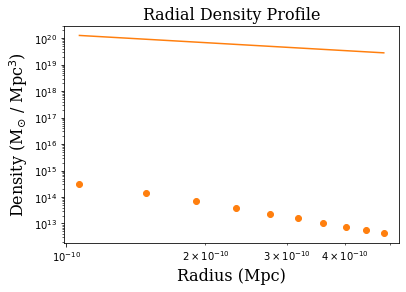

3.540711173850651e+23 3.853911600736966e-14
6961063.748627959
6916943.532926645
6938974.379101732
6894854.163400502
6862224.7056196155
6839554.345965125
6789966.335303152
6735721.095233761
6646474.699362503
6572542.335114957
6427708.142418592
6287067.231118942
6040102.228207544
5817737.166348712
5404126.737040359
5028687.465758568
4344182.8176440755
3705555.401144413
2547303.749191015
1525129.465332942
53356.170957971975
179090493.42750442
2705512.087828867
213162.01023494458
13235591780.080496
1039933.0557158178
86044984.39597759
332295.84263905766
5902603.600161565
74277.46004450254
172724.6609692606
79999.29661865733
58596.3844742381
510142.2621442189
31250.228426655995
33083.743340164016
77057.36968719187
32292.32671093693
33630.95708303542
30613.172948668787
41572.813286815275
29915.47014018914
30603.01796397258
33200.1818205277
30009.852659886994
30093.55681540408
29899.61185434909
29700.3378568404
29600.74718175504
29571.508574218868
29611.007390837836
29260.072954981435
29115.0

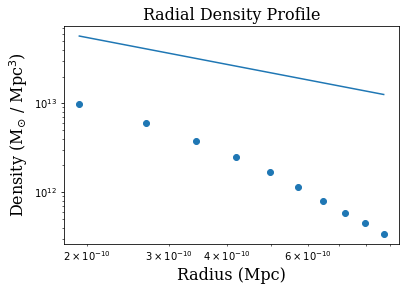

164876052925094.8 6.667467763579293e-11
1679841.5217998
1669744.9805064064
1674328.7489946503
1664232.2077012807
1656546.5680421665
1651802.675707
1640570.1868067058
1627490.3544288743
1606704.7963303889
1590309.2431748635
1557192.3316962572
1524040.799686984
1466899.176817202
1416485.5155402557
1321565.7964108025
1234319.735784815
1076641.4505571567
930643.9036340531
664772.8350493108
429207.6851092986
23561.757339337524
8505836.708636062
700354.7362683327
6713.568518754572
8505836.708636092
506883478.8347455
317785.58235074184
4184112.5088516935
148996.03578851654
230144.90356224458
71653.55110122112
18928.40060270278
71908.61508917363
7445.159232408338
43784.34986729589
3829.2950141128813
4154.80716208733
19964.001142977948
3522.2789533850505
3812.4997759245466
7064.295137257838
3240.9780710252417
3261.3594547220337
3985.31248488636
3261.743313557928
3478.3585193371036
3220.9935509247457
3310.482935182891
3232.047136018578
3198.469257229015
3175.511170642908
3193.6213630571087
3138.

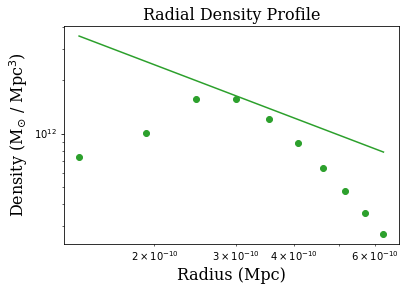

1161937032889.032 4.2235682459961754e-10
1779414.9249079279
1768539.8322424456
1773640.7916654362
1762765.6989999772
1754565.6076741088
1749297.1185246091
1737157.242757623
1723307.082195479
1701048.2597481215
1683201.3466159184
1647521.0479789593
1612158.9110393994
1550834.685030117
1496364.6613548757
1394221.551475122
1300722.9489940542
1131255.439557643
973947.474138239
687865.3099689089
434712.1394577982
11513.87214326803
14641421.773881337
726413.0693421356
3423.7428693016445
14641421.773881292
928401698.421917
314781.005322478
7171647.73488047
134477.3864601373
441114.9214965735
54843.41184074716
55804.1171177561
23773.400069428142
9588.927115763116
47903.475604748885
4169.257828788315
10870.066908061388
4476.439083231457
5824.359705106027
3517.254642203671
5747.134668440701
3478.952017568632
3498.566425699779
3404.9186418223576
3448.8240034629725
3379.9051238765105
3424.0428257244193
3371.7300508525204
3604.216532787006
3358.23029895011
3376.263733252673
3363.2724247677315
3391.

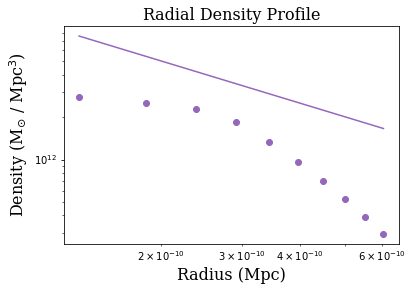

4996378656730.846 2.0150578089960124e-10
6519647.636529804
6479195.980567586
6498964.806640666
6458513.150678513
6428391.413160457
6408023.206648082
6362666.755792498
6312306.05589453
6230140.274882476
6162846.665318733
6030080.845179379
5900226.214915849
5673209.106117733
5469776.960824363
5090306.058353274
4744837.414806131
4116279.157241722
3530890.6586866
2468180.0627000304
1529331.422824453
24496.24440633873
90188676.88056621
2612652.258124676
49008.90306205781
6316146522.233647
1083552.2792598656
43579646.708621815
419813.50522739685
2817614.5829925947
141770.0143411082
462035.1991262059
49133.81775690129
125870.08813699964
25464.692338823286
80744.37087181484
24001.158152176686
25633.918277021137
22708.355346140357
26133.500319629427
22226.47985836379
31657.704544963588
21735.75912940731
22165.652518859853
24633.734271880006
21715.43320598375
21810.899151275335
21669.00960635217
22070.006927938262
21659.72424877487
21588.187828771355
21537.76619396868
21670.442805268933
21616.60

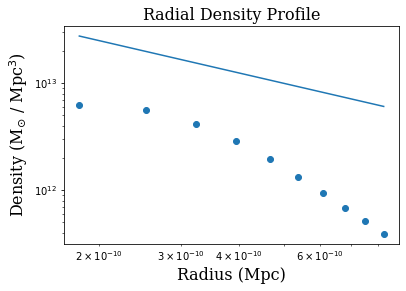

42064778137592.48 1.1863644864285921e-10
4774034.270254418
4743595.614676342
4758648.151371219
4728209.495793235
4705628.032967166
4690130.270931471
4655956.270832358
4618318.396670507
4556629.952544371
4505792.786174304
4405880.030870511
4308538.314469401
4137951.305140522
3984696.257840232
3699257.3281277446
3439798.3641304
2967203.6259479197
2526663.6393386032
1727304.9730934496
1021671.4421048977
60640.147184070855
135350190.6999846
1836230.2738611554
207888.54901534657
9464694435.350307
687438.5257684592
65795083.88204925
205230.4329364923
304072.3190043378
32776.06194779581
1744140.2824312025
60424.50501550047
91287.60670605596
28652.082625756375
200242.33637911238
29896.15097744128
34259.57201653697
26869.259331560854
56426.26328406569
25576.599289237973
26100.225142671276
30940.477201723585
25465.477433502543
26186.811953312048
25583.54023060883
25614.048434665583
25455.843302105568
25484.92443538928
25400.655995364792
25476.3995758645
25396.844103927135
25696.700052057728
2538

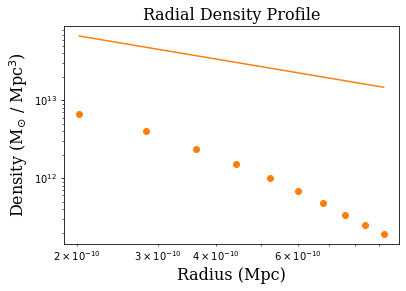

307442737543239.3 4.408669958193869e-11
5892059.89775754
5854076.718382961
5873190.907096316
5835207.727721859
5807187.041544438
5787527.428715813
5744799.745891817
5698313.97708819
5621596.594212678
5557781.634544946
5433084.894638699
5312312.941531008
5099894.022286967
4908313.493872604
4552318.652054919
4229503.483286138
3640509.9627172393
3090673.1359290164
2093768.0122962978
1214516.426086158
156764.85880659136
239002122.64736265
2230131.48897202
453015.3965483672
17416614569.241558
798253.980529171
115443811.08394358
209842.05127157643
327335.4152925952
158972.31314423945
268493.5931023809
103489.0260886538
311483.7262964838
75396.9573040642
369533.3472318379
42492.51999246582
54564.76423433615
197051.84643781127
46062.97079533191
60751.104664972554
43838.62853327478
63010.335987069295
42104.12351403577
42805.74327204012
41974.51017870899
44851.84543365447
41832.97614654453
41791.004751535336
42059.335958666576
42515.002549515106
41787.457710358314
41706.94010425781
41682.9738586

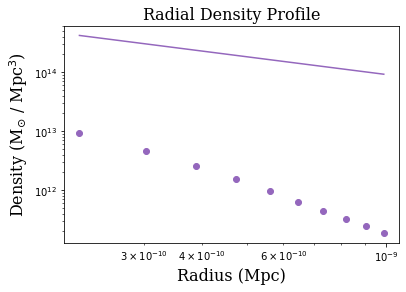

6189652263468051.0 1.4727605722422086e-11
2824172.7690333724
2806719.030801289
2814940.6920825616
2797486.953850532
2784343.007372051
2775853.6649684818
2756361.219316407
2734183.425497354
2698486.900462105
2669804.4241207563
2612538.059392767
2555856.9778078566
2457481.9628236284
2370026.889517608
2206114.301585667
2056150.6863186816
1784237.410169638
1531759.8625496477
1072672.9201097833
666525.0650730307
12104.185273212239
31018780.699506845
1134576.5804611251
16574.01126729625
1930527374.2723598
474251.8145036622
15311109.49781495
187581.55993551726
1030486.6825266607
66611.96281077717
165528.27053509926
24772.321496462922
43138.10618595514
12787.40742459416
39154.01209861531
9528.108725053338
9902.304683988685
17446.567861985226
9801.257279957645
10027.428020915026
9533.083854816516
10956.111662143217
9463.28287766337
9366.072884004265
9341.856169013157
9812.045710679522
9396.17578220462
9253.035602434324
9165.704695599812
9087.352753285386
8994.918632245084
8691.737900237524
8371

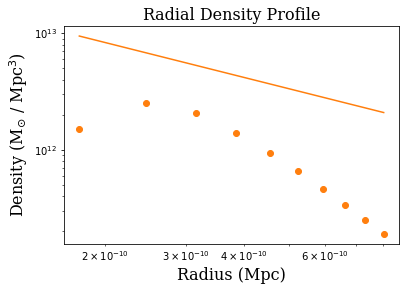

10960441872722.885 1.5284827349274805e-10
9341174.8138898
9280738.20398001
9312911.815806946
9252475.205897223
9208731.619338555
9175742.398920633
9107313.293786729
9035910.69691063
8915237.488416677
8811684.334978366
8613169.610316506
8424729.200595073
8089155.832633495
7782499.218562492
7217097.080667678
6708597.8152504815
5775447.897302481
4900007.156698783
3316945.276594454
1923827.3226007754
365305.01706541644
584791664.1269822
3536363.8727087546
986887.2247468075
52292628598.75482
1260930.166085993
271640658.2507124
329383.2485271758
515663.101928194
251920.17080879537
1038641.4440135729
95747.7690448049
100866.72189212403
469127.3662266675
137332.53044593017
174847.93828004773
104266.74340921885
114618.91090079064
95979.12797130132
118915.00791122364
94399.42397391955
93895.56354549754
95450.2972423566
100500.21127460907
94016.84871990967
93655.04794371617
94174.84584187492
93379.24714255797
93614.20763488417
93305.2382534629
93935.64647006121
92854.74384788329
92989.89714903214

383.33565182451275
363.7845339928899
360.79358483046235
359.4527973207878
364.17509572762356
361.88153134658205
363.7261800076012
361.1082109306517
358.6655561174266
358.60502720144723
356.3016704404072
357.81359029901796
369.1448478730854
357.72034881934815
356.49956584442407
354.581543282271
354.1632517126054
361.3867712844076
355.21642328298185
352.6740119732567
351.39555820641544
357.4623527788426
353.6020329970779
351.8346371786829
349.46136533634854
348.35045676244044
352.774406742712
350.4308445807983
347.2016893945911
346.1251477620099
357.45756165858256
348.35073616822046
348.77276250562863
347.5209458296813
345.28164372635365
344.15080894573475
345.934427242144
345.31660367875156
342.63432476713933
342.92395983413735
345.901669359715
343.27146374936274
342.3282962984522
343.93401245985297
341.35466209043807
340.8768300249576
340.8010933623227
343.1805268125245
339.3517141371849
339.3329936345908
338.1402590090511
340.97071568238607
337.8290298657739
339.9212468573678
336.8075

240.13400593044935
240.1116385202331
240.04639676233637
240.48637061402405
239.91176997141156
239.82489899606298
240.7112291533922
239.98392472437263
239.8773299159875
239.78036468604114
240.91385775600065
240.23980867965292
239.77265339733276
239.68750510978134
239.8240284624626
239.7740475634928
239.71858600961423
239.7022009729626
240.3952280851081
239.65863689473917
239.71080952634657
239.66720983547566
239.6372017024405
239.63919149080175
239.6897437916923
239.64769901982072
239.62744840547384
239.6230840242497
239.60080446029315
239.58058972476283
239.603074409315
239.54273483856377
239.5122094240869
239.53882219726074
239.45246660317207
239.4118389324649
239.62141819614772
239.48489299176435
239.3893371876693
239.34570028315648
239.363606596904
239.26650666724163
239.36401587751607
239.34499405228416
239.19820885854278
239.31879634402867
239.81283606324723
239.24749787834298
239.22425240874873
239.14674244911293
239.16480091282574
239.3274368474813
239.1785736413076
239.14234257

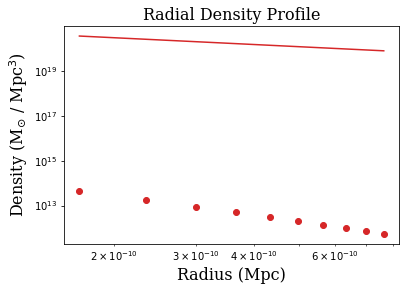

4.964937171373021e+24 1.1933893029386563e-14
6509602.930797314
6468365.935402864
6488966.00362659
6447729.008232221
6417236.032437371
6396038.626965454
6349688.898555892
6299001.348524931
6215593.850436855
6146483.14381399
6011113.230810175
5879680.843421894
5648865.449523301
5441023.789242119
5054447.048066339
4703562.850674206
4063802.718023527
3466907.4881758722
2384354.9142789296
1428993.5740789378
53342.79673523253
165634595.06052047
2532228.843858191
201888.1634526646
12157248902.558262
975523.2391457058
79685820.28080045
314252.6842104354
5488233.668809932
73159.49098505291
165173.83689433272
78522.76799668389
58169.384189927674
478305.1712186313
32880.90253838744
34627.70860148562
75765.76682282222
33792.790260970316
34993.76935370437
32291.558797016743
42569.186955777746
31607.947657549477
32255.529634840488
34643.16003243614
31714.120406245336
31786.770477036185
31604.013796771294
31399.69095291544
31293.41306210652
31277.80714099944
31310.3609639186
30954.162809426547
30790.

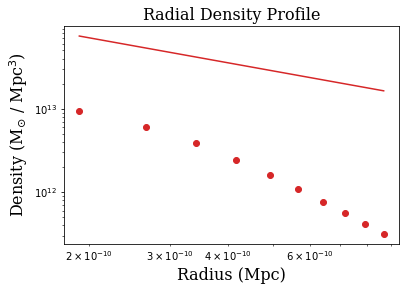

267574335871881.1 5.3196690081491136e-11
2566531.8415375124
2551417.7511255806
2558078.928575232
2542964.8381633256
2531364.1015078784
2524457.039451088
2507693.002246458
2487821.447021169
2456548.158316416
2432233.3006202243
2382670.5892682783
2332622.170619726
2246811.974444801
2171549.9591230326
2029342.6448446598
1898165.8902078676
1661688.638748393
1443198.5428609806
1044858.7698291064
691552.4032681526
67680.99390670485
7818418.911354043
1097865.8268701772
31222.31477499784
7818418.91135402
467206805.63425523
524625.9879352114
3796605.835397085
269965.32471723726
161777.6430474125
6974.644335465825
36933.01253372297
7668.846815999006
103216.52805833485
10331.255045158612
32689.90418021663
6042.237386814486
6320.918631570203
10796.440897581675
5807.020198991508
6019.905251465057
7310.005991455015
5787.297418553655
5858.776122219145
5774.385519943817
5965.855311723786
5766.274865161375
5740.192729177763
5722.668449994547
5779.345708420159
5750.876025504314
5715.239585660474
5711.52

5153.231125087674
5153.624613032409
5153.198097946928
5153.24329026699
5153.117529217572
5153.199348052161
5153.109938927454
5153.165774576673
5153.070780670569
5153.1474271778625
5153.069050750952
5153.224620300744
5153.058370514555
5153.076424847761
5153.061271743492
5153.053328510119
5153.064957239088
5153.091460724249
5153.053862888102
5153.04738879375
5153.044133192148
5153.041514094952
5153.039066475796
5153.0264719941115
5153.017646214717
5153.011471127427
5153.0110727147185
5152.97381537248
5152.947603644232
5153.00718483821
5152.924410263397
5152.92565899757
5152.9253884656555
5152.868089363652
5152.865391155048
5153.204573739478
5152.882275819595
5152.815668514319
5152.781890474969
5152.85737185151
5152.735579868258
5152.74485025283
5152.794012634554
5152.748920083622
5152.708144235774
5152.835170531387
5152.999074280928
5152.713065283388
5152.678687216652
5152.668192552083
5152.659738711406
5152.707925799539
5152.630370673642
5152.645875947268
5152.631969366199
5152.59046521

5150.292823326015
5150.290273627873
5150.28827355184
5150.289493205065
5150.284364531846
5150.286772681664
5150.290807625962
5150.287061578908
5150.28286404654
5150.280504455009
5150.281593577991
5150.278700523095
5150.286533508452
5150.277547130024
5150.279850787138
5150.277568538162
5150.274559132144
5150.27699857303
5150.285848244357
5150.274496353742
5150.272673731935
5150.276444522862
5150.277909649472
5150.273423685623
5150.271157001545
5150.269773501093
5150.272723569439
5150.271215972515
5150.268682741506
5150.268015822383
5150.265856394905
5150.263890469005
5150.26817359139
5150.265480092843
5150.261337746801
5150.259028064331
5150.26081981939
5150.2556795976925
5150.252211113605
5150.257571095944
5150.265671208697
5150.255405730348
5150.257665594616
5150.254262807313
5150.251285872449
5150.2516250494755
5150.249561296025
5150.248666815933
5150.246908035522
5150.247491186505
5150.245415087056
5150.244922040381
5150.24102312418
5150.244329768352
5150.238418280937
5150.234263351

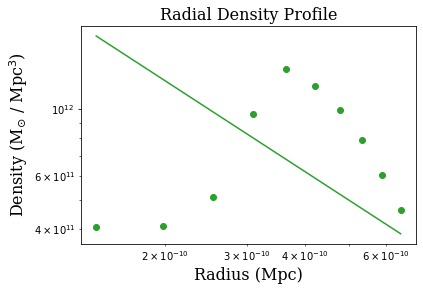

89374386.86802602 2.7829202313055378e-06
2225603.18650284
2211950.5033013537
2218240.7475985116
2204588.064397079
2194239.2100665253
2187735.4427564805
2172523.525988021
2154970.355981187
2126935.9784333436
2104661.3700728505
2059874.7848016792
2015239.0586950667
1938094.1569785753
1869831.4696239182
1741532.4135250093
1623813.957430265
1410793.266816757
1213346.206288277
853982.6595399376
535780.5799121059
13188.454137407949
18899578.53223776
902207.3575312753
8251.495792378417
18899578.53223776
1105007112.0093696
385337.97076234384
9416816.855515836
160032.30278606582
625466.6492347545
62616.459307965066
90996.33473944262
26348.820299079518
20672.69044155351
8946.154467654504
39026.15986831168
7592.255336855346
7861.347339945305
13633.567132158272
7063.643463705058
7266.093085690502
8588.640498668477
7153.601442885479
7220.78079121373
7107.1390457418665
6995.43874864327
6988.579277505009
7347.216227009721
7015.936456704181
6897.924700109541
6809.257144044186
6787.087151910509
6664.06

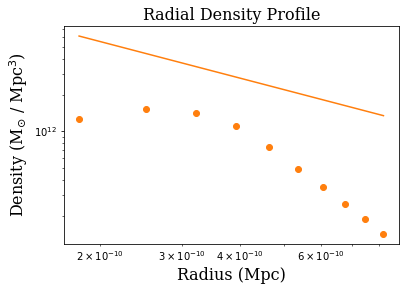

6212906061322.155 1.7775658028737462e-10
7685983.840976881
7636609.893179041
7663234.769222927
7613860.821425117
7578287.503471567
7551005.811953398
7495016.641532151
7437180.64817761
7338867.710221489
7253877.642432079
7091679.893310206
6938458.607922037
6664784.970501934
6413901.734735174
5952197.494655826
5537796.790147794
4776265.746614929
4060954.5808805516
2768302.448243796
1631196.223042858
199421.4439407398
434263262.98754007
2948063.6394344848
590717.9608996585
41968060870.8775
1088469.6417118507
198548249.73355862
311592.214294714
471725.5217743902
242974.33793342963
339566.92984649015
164751.0608658264
399370.5281803386
124316.35930414229
526471.1677509659
67387.16038127628
77534.20297473174
249921.6000104981
78206.33690976974
118045.21914902012
68367.90156699666
81161.55942360869
69249.21402721279
71858.80740397262
67666.32696438412
69441.51201831677
67592.99047311448
67884.60978539751
67475.18194799621
67664.79879500944
67462.1933754537
67419.54869751597
67313.43482162803


377.9804021754135
378.1059749992237
378.00584427122885
377.9489945596506
377.91599436834076
377.9382092644373
377.8764756062519
377.89775961084524
377.8798712945063
377.83229177415706
377.8780819032618
378.03170793404934
377.8500253578495
377.8143725971604
377.8112356204474
377.77085609027927
377.7577089525512
377.73808934001136
377.7244413075423
377.79613107255864
377.6994509777578
377.6625387427448
377.63922069554974
377.6976288827791
377.6694403238689
377.6299255582344
377.7800882563024
377.9368695926096
377.58413938037484
377.5836401240558
377.94671790009306
377.72104407399456
377.5814577746132
377.56519591830875
377.6280775255909
377.59952386279474
377.565119255436
377.7079875655036
377.5647635537571
377.57432684203013
377.56105522511643
377.56262197995966
377.5579836243669
377.56365403787277
377.5792964254506
377.55878230962117
377.5562407493635
377.55655217424646
377.5557300448345
377.5578863898372
377.5540860749861
377.55465559875665
377.5542399389851
377.5522013619666
377.5527

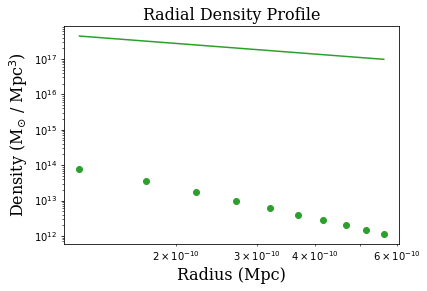

1.1887522144038042e+20 4.607171861719907e-13
10037875.945655212
9973921.445587281
10005555.82685344
9941601.32678571
9894159.018344425
9861589.582423665
9789784.850366957
9710714.868292846
9581107.082840461
9474285.373262683
9264358.774520893
9059848.977387086
8701437.594146954
8379428.20029344
7779697.448931316
7234563.700239623
6241604.004306945
5315987.0734540345
3636461.5798114617
2153857.100396631
129920.95755611961
280125550.4082777
3865323.68941821
434604.2485595604
19478178192.414738
1451599.466473634
136315454.39233986
438157.1166123983
9851633.22953486
95017.35038806927
219273.21749639732
101725.94182128238
354783.3271322993
58782.85883410149
58818.7425389804
135543.65865302272
65970.09279582794
79359.74975974823
59284.553169117884
65129.73185289609
58196.52035357057
59457.25973557256
58421.51963213205
57667.3120268263
57309.07066856148
58459.92166128973
57912.247093223355
56875.97406906352
56171.7769475542
55796.955142059516
55506.82906325587
54121.421408920105
55192.7980296

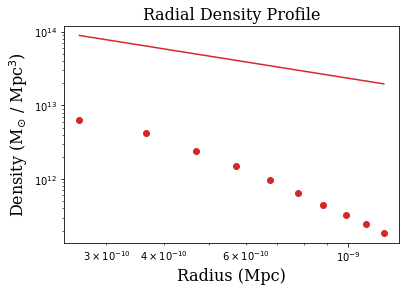

505753453874964.1 4.6217838989153326e-11
4456492.77634578
4428031.75343564
4442222.070217756
4413761.047307681
4392702.1800578
4378098.831572551
4346116.009729927
4311092.305217804
4253504.075376378
4205836.7278483715
4112408.51800331
4021637.80022895
3862295.2538947985
3718875.412122967
3452050.9004597967
3209796.443600421
2768183.5664352756
2356226.160971575
1609022.5023069796
949641.2427050301
53722.629253695195
137217319.1204943
1711044.9962189717
197513.49150076386
10075871912.49306
637022.4358366253
66082345.72340356
185798.81757344247
278478.7796166344
26390.73345907435
1695103.8942610412
50478.82708985725
79185.8647200849
22156.55878421116
189785.29603319787
22386.82961876579
26330.142290047916
20852.095864521452
24570.876166153274
19510.919965999095
34143.640181021336
18804.47017471779
19423.145139760723
23344.069957939893
18715.390016008878
19275.66645226549
18835.602558030725
18896.313559662776
18730.793956100042
19041.571067857687
18712.473034537754
18682.96339335665
18681.

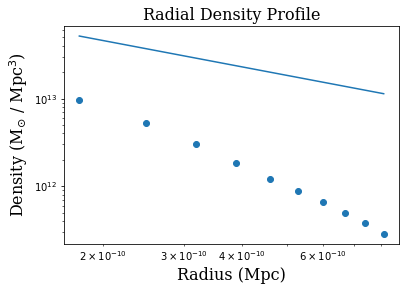

160801281707035.47 5.72394990862016e-11
25907894.72888714
25744809.699058276
25834709.021371245
25671623.991542406
25555061.990404904
25463045.86036479
25277618.12480651
25089437.998225063
24766269.664089113
24483284.93670517
23947419.554937407
23445506.791769207
22544294.402358793
21713533.769972768
20189675.785985664
18826820.10740028
16316187.142303837
13952789.980146404
9686853.66236145
5937178.745065702
161066.9338125584
978850595.6960232
10283612.587357342
619186.4440099968
111864509912.35321
4138185.8078053924
432028368.6663676
1477241.8892683508
23117066.65900466
414965.22914856486
848857.5537948244
172808.76737556432
1589215.4482176583
178536.32484180402
542746.3887744395
136383.42204337782
141085.82801971963
186195.35622203696
139700.06180665258
143251.89767738225
137401.4582489972
145768.2315726115
136758.985735828
135583.9803205768
135588.52244242287
135372.6880874175
136051.16753882996
134346.51532044704
134171.8563673594
132820.01083003287
132038.05711506595
130125.899769

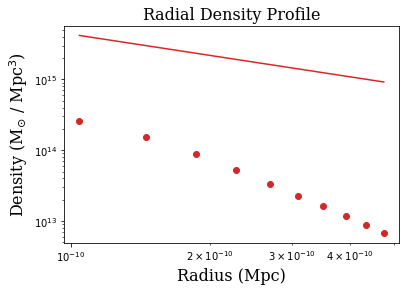

2.8292790293615732e+16 1.5450552566988325e-11
3574957.7195271784
3552149.086145276
3564838.964403911
3542030.331022012
3525783.81562721
3512801.744196286
3486838.879048287
3460689.98869573
3415584.001969072
3375874.248959621
3300922.6603856697
3230970.1987473755
3105084.6582385413
2988779.3287614295
2775723.4361231294
2585443.796470273
2234560.1333100377
1903987.1469575693
1307555.9296419325
783554.9970519519
62252.11593300668
208939390.05979943
1391158.8499372767
203940.50156487135
23986112887.797043
532311.33358588
92317148.94630113
167043.39478238625
244582.86726436683
36652.377148060485
1761488.719582614
54603.286397175274
77952.86208796717
32327.429896152727
194413.14644433383
31239.691808979864
34631.043163821094
30108.289449470685
47709.31819358102
28640.462659621953
29146.67495351651
33398.03540133752
28816.088145761354
29270.65119474684
28744.736160861554
29412.0047273044
28651.99544285539
28604.624437886796
28677.812553026433
28547.53255069011
28524.229680289158
28474.3695572

200.36485012355843
200.18950774540463
200.21813013347128
199.81897540410682
200.2381289115674
200.18580263200965
199.56486818289886
200.34950537112672
201.7935336576229
199.74179307906343
199.5596190192955
199.70690436154655
199.41827545135675
199.94231678148935
199.34318436964713
199.4398136716809
199.43743328942037
199.27767012781987
199.30765039438847
199.16339289762436
199.33253404876996
199.94231678148935
199.17035098635097
199.0937362357745
199.1183317339346
199.0681965181011
199.0997127978535
199.02155652173496
199.05610495851033
198.98777211406923
199.03919733233124
198.94879005308758
198.9841022415676
198.92086295739136
199.00258526758262
198.87344786055473
198.90152453346673
198.86938108331015
198.99546417974125
198.79668999357273
198.81077102594463
198.83852680710152
198.72294460792
198.7175594920809
199.10882422156646
198.74188840214083
198.63497774096322
198.584337321945
198.52861453164223
198.43515336127166
198.517178301081
198.36712202628405
198.84917159235192
198.366603

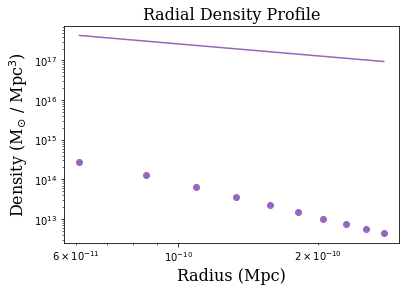

5.478485124441035e+19 4.773977499868561e-13
3259879.81295616
3238873.2156586247
3249206.877110959
3228200.2798135285
3212589.8812842863
3201947.627774605
3178376.8765025
3152322.0666794553
3109705.057111585
3074684.303726578
3005734.8890536386
2938438.60024116
2820633.2829048536
2714926.8301831568
2517903.611615153
2338672.338901357
2012381.3257659748
1708372.2817595382
1156604.0509822029
669556.1823096009
83357.75680545955
116390378.8820492
1231683.9631578485
239638.50902607225
7801594678.896527
439537.58751611435
57131390.28637204
114985.78198856437
179358.8008926604
86902.07360178202
143044.6343323328
56508.52571078748
165305.37116683437
41047.56285877885
202786.34020437312
22726.36083645543
29059.391751906103
104821.39628451121
24865.752874216472
33013.04411039152
23418.000059994956
33511.408141259475
22614.270874459555
23033.885674004814
22540.172411101034
24188.496481131126
22418.702270131278
22390.319509879933
22505.31369069575
22734.854908660604
22415.37000808127
22366.82365962

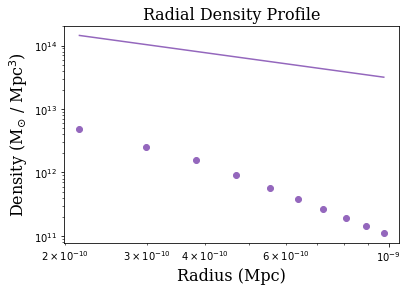

1529038083270775.2 2.0209887200248225e-11
7381982.0924281245
7333997.681009401
7349095.838122714
7301111.426781118
7261384.420199997
7245333.282402885
7193633.814383558
7121726.275539373
7017624.352939336
6947379.260213983
6790387.104069535
6618625.58266529
6337803.830003804
6105204.610579385
5650124.912803522
5215670.6121475445
4450674.30102406
3759070.1710406216
2483684.650805738
1347456.542440075
281544.120838051
86428399.18168396
2642997.9899549847
613442.5674451191
2205490807.073598
837006.8314531835
51137608.852482155
172062.9438446517
282249.2022820472
122666.85054925484
665931.4043557934
59929.90219993292
80939.1642121882
353872.66452215577
67045.40262199966
92684.83011295121
62141.2739708506
99254.33471181069
59249.2510358331
60114.92853946907
58782.125595009056
64577.23815781562
58605.87699562379
58495.46218361537
59177.74924280451
60040.87174388652
58452.859247407534
58206.34545832579
58031.399422646035
58508.593480396274
58303.318570765674
57910.92291467979
57706.3531587795

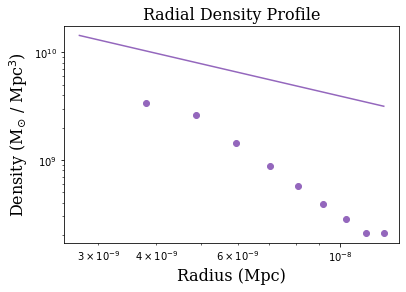

24021782477.763622 1.6322742915386487e-09
4321394.657841571
4294254.482492634
4307577.770532656
4280437.595183771
4260256.625955429
4246533.000536028
4216086.991116077
4182385.602935736
4127305.5687407046
4082087.9815438436
3993008.0368138496
3906011.250917939
3753780.918698662
3617230.536002559
3362667.7841882114
3131057.789678263
2709477.2842658493
2316703.829639902
1603811.6958829286
974197.8496475
14722.455267387391
82212809.88534765
1700825.3659067666
69762.2017457283
5846566767.226789
675438.6126676042
39716787.10908889
235024.2907624878
2680494.0996484812
61981.04173284387
131020.43517149024
15699.004445916751
195144.160539834
22226.047337604603
61553.54277333376
13557.97601882551
14545.062263932645
23369.60190022286
12951.400647545279
12954.32414697353
15183.830025003188
12899.478165932309
13472.555692919816
12838.685523750391
12716.755519519853
12683.842795082877
12517.961635911099
12413.512488516977
12209.480431217395
12320.067875705055
11862.519981081585
11553.147248731433
1

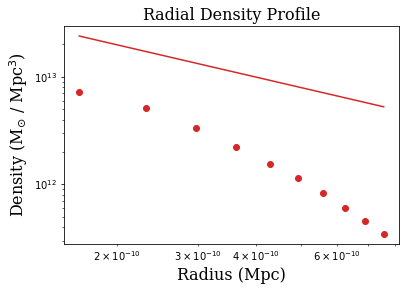

36563384208623.75 1.085609004964554e-10
1989584.9499320458
1977098.8732378776
1983342.99985349
1970856.923159338
1961627.2977437992
1955202.3662013856
1941166.543178651
1925828.861569519
1900579.7230628482
1879645.6912869853
1838656.865017615
1798876.011920309
1728998.6329417585
1666058.3935794907
1549012.1282007718
1442793.6608439542
1249104.390935448
1068368.128850961
740601.9169989035
451326.7074621759
8155.072520721715
40430920.29938954
785393.4418910639
33329.3438709935
3048758301.8549337
313824.5823191039
19314550.68809046
110904.63756929772
1265122.1307811853
30636.157228327003
62864.80794996972
8578.240943974251
91270.56218410353
11971.847414645797
29472.06236634763
7787.961033324486
8294.397383619804
7615.212427579758
10660.186184601815
7446.224120431078
7642.819591797321
7481.135402190601
7933.937793275758
7465.060373935361
7417.582141602606
7429.422004966465
7410.484675299552
7453.3068147787635
7370.571108657107
7378.00799454927
7373.489684053875
7323.690226392676
7327.29420

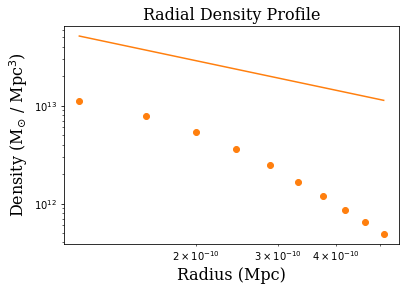

106095026325973.55 5.447623641318132e-11
4571381.307008031
4541830.602877296
4557156.381122888
4527605.676992209
4506023.251697092
4490286.601319073
4456930.098009048
4421427.013474815
4362102.053775042
4311933.437151767
4214893.022264147
4121896.400788751
3957260.5287797586
3807739.7560935086
3531045.770485653
3281229.3261559694
2824037.867805525
2396119.396420712
1621350.8141905335
938831.6894030937
152040.8225733439
236300974.97389236
1728075.4965409914
423690.8271020327
19208792439.558678
614858.670765015
111790603.82960838
158720.0985008953
249755.70095196652
120195.48987509892
253717.34025438185
78453.22406526697
386730.5837197065
37856.310540379316
52527.6211072904
213443.14710382832
44178.569237057876
69529.0899333001
39119.17378981678
55094.77422598511
38757.560692706254
42079.97500739713
37875.22308660388
39993.22917238018
37942.43981363566
38513.78078970579
37801.69054692816
38030.596109506274
37815.50248245132
37727.52592957897
37665.77805491736
37758.27230405736
37596.5410

170.23010181906284
169.907570699168
178.94364865949137
169.59971711418984
169.98219075533962
169.61990530522417
169.50248600053237
169.82010162383995
170.12931733179175
169.46569926241136
169.3141429419975
169.2122884944165
169.5329847285011
169.3820822037087
169.14026362245022
169.02184762389516
168.90585898509744
168.99392547003845
168.71390632423936
168.5423682805722
168.9239306268155
168.69210987068436
168.58273549072692
168.34377227159348
168.24669344519862
168.44198718936786
168.068679681739
168.05974413012336
170.42547344780724
168.19039088132922
167.92454965612342
167.8404166459477
169.18050201618098
168.0107023211549
168.29982548020234
167.92771420319696
167.85526603665494
167.76228069852004
167.91348483931142
167.8338227925742
167.71470145197236
167.97680551538542
168.35590124894588
167.73327731749487
167.70058347682425
167.74330603545786
167.7030780284058
167.66857917105517
167.70306824399267
167.85008469166678
167.6649917179966
167.6568267162911
167.73853942295864
167.71409

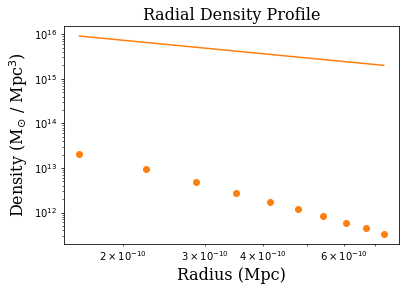

5.631500418706951e+17 2.595550779499827e-12
25102523.50398764
24940642.102492742
25028721.33459021
24866839.933095403
24750581.31348585
24660372.083333306
24476603.82167843
24288120.376210317
23966405.069251467
23686852.324477196
23155011.118689362
22654306.518635295
21758092.882230535
20934714.855919644
19421395.200797856
18064995.66127395
15569965.260639211
13224434.35102955
8987648.587392136
5262275.742783527
817383.1383063387
1672070044.5740561
9578110.080077669
2336273.313079879
167710116387.86636
3483602.1890667593
759273381.2922521
954877.0589010456
1471668.4068307092
737440.4425084571
1365705.369484049
493785.64207312034
2230003.970744681
235719.70509343164
296809.2984337149
1152843.6279290891
284807.72935653164
441758.23082922224
236517.87795890862
308903.19822721585
246519.59733058032
253173.17657521242
236875.17713753143
239531.4630561862
234677.12826496406
245687.369352921
234278.91389223293
234218.38053015695
235834.23563915194
236909.47656175448
234064.5262725814
233686.6

325.4838591347507
323.358359112739
320.753222405212
327.9963818401302
316.5373004616704
314.7050515048177
339.22160956356674
319.0337615993485
311.7766879321134
308.5101317095541
334.20336253294954
314.38893068044854
312.4528347905434
304.59334646287607
301.9162607751932
320.24523381989275
307.6221517173253
299.3585230775061
297.08575383608695
346.9866522049997
302.3267914317694
307.8689212744648
300.0277478609787
295.1164724114642
292.6071035287023
297.3084865936544
293.81769782840274
289.6154365489201
288.2634879457037
286.74910977807303
285.39959978696425
290.0858048570808
283.9402671463613
281.8892628045578
283.155101704906
282.5349095907586
277.42318827049166
276.4728956560575
300.1313784974336
278.10467957056244
274.3423932667647
286.792724744897
270.29954496173013
270.4618712943775
284.548019788519
273.25324750473374
272.0672062692465
267.5642837172345
265.9260772736161
274.33793475119455
269.17102782237635
264.07235893064353
262.20006848442426
280.51871283951914
265.94625420663

160.78255480709777
160.78255508597067
160.7825548161636
160.78255500596424
160.7825548051478
Optimization terminated successfully.
99736232206398.2 7.968221159640057e-10


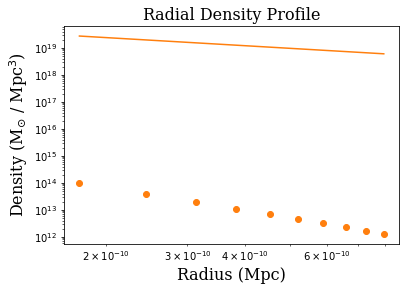

6.317439154137258e+22 7.548865759845553e-14
2756822.8733358793
2739830.096705788
2748179.524321444
2731186.7476913724
2718554.924594985
2709954.9313337463
2690890.437402559
2669800.820341213
2635320.935841242
2607000.5580945653
2551226.1146111563
2496773.567205484
2401472.25314635
2315967.474373131
2156587.8739080084
2011601.0640520784
1747667.7162697613
1501744.282647374
1055411.0013586185
661164.007362572
13180.975468034892
33167569.907443296
1116169.1647842862
12110.179822921644
33167569.907442816
2398463906.8232203
473769.68365663
15899196.021968745
193300.8692400118
974642.7971948893
72116.7359510771
143727.92685152515
28021.32681817456
33658.85580857803
14060.568718656648
13371.056840430458
9174.560622104953
42969.69766646641
8361.71225978003
10098.251204096085
8523.019854698749
11839.909511969392
8238.42780908312
8265.353463996753
9279.304864659985
8169.003195254814
8244.6187358927
8193.127976863972
8304.686152233413
8186.63054435738
8157.126169796642
8150.160781242783
8118.6016

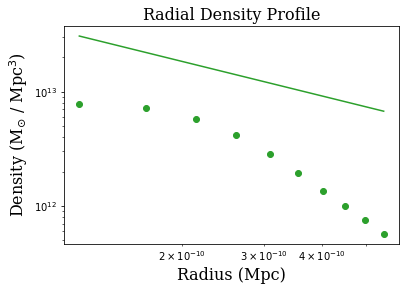

37821034402780.92 9.714012533274187e-11
21996526.827941623
21858787.896856084
21929915.95090693
21792177.019821476
21691435.821267497
21618378.86393526
21462978.315880068
21297054.674152423
21020304.613696247
20786798.041488096
20334500.242394377
19900424.78703407
19132673.97220722
18436016.10581995
17146159.065570615
15981028.052293425
13849548.702864125
11855035.18035728
8243395.3529581735
5059887.3634630665
92668.66025505518
494486191.3335415
8740677.566056028
336299.00822164095
42286928223.79086
3541682.822939302
230520397.30772483
1292849.9751819558
14046815.156400757
382255.2538896882
2458974.361683271
121923.31688983836
351587.2845191355
127244.5045423216
181994.29403185865
92820.9424467915
192326.26734526237
93937.93135304062
123483.25869975882
89689.42903991166
90831.76232035836
95025.28496923755
90511.5965413898
90035.21356931672
88692.83500691
87964.510259739
90053.07873389675
89131.76154759168
87307.6313472058
86108.69281822695
84703.25620016945
82836.42488901483
79940.5052

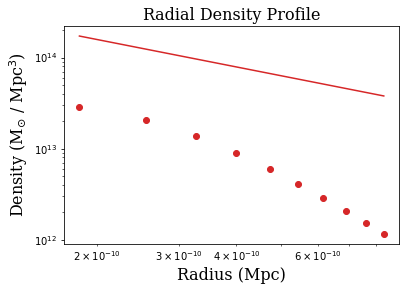

446557636035792.6 7.062422698311503e-11
3299476.9747840054
3278287.4702670197
3288951.2853837023
3267761.780866772
3252130.410005654
3241162.2307096734
3217325.769924557
3191394.1039808164
3148596.974615165
3112995.6385458037
3043431.5807488686
2976059.510147213
2857560.6673663165
2750682.6762879193
2552086.433891661
2372005.920021996
2043434.942597629
1736698.5869217059
1180565.718055801
690022.8406328864
67045.42208693919
122010121.3151557
1256646.6641639567
208208.98692106974
9017337847.940817
457553.8981936363
58741813.08215967
125908.04144492125
193024.5853814234
96362.83958900606
119350.68455567227
30898.236126110918
997001.1746263601
28310.952500942487
48975.63167802103
28296.99116259663
78912.89792187921
20401.866500708962
20488.86007590879
30991.91009776266
22461.424044985997
22992.97450314863
20932.668159237557
21097.056878677096
20553.06505645369
20622.604863302873
20464.549706168535
20383.20364602773
20363.73999763434
20254.716301990855
20148.547978172108
20179.49336748443


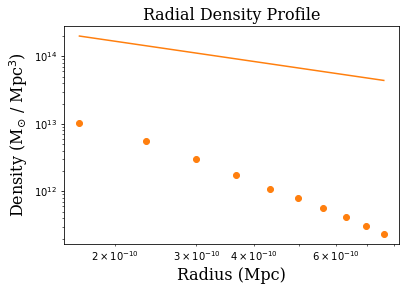

1660772085295993.2 2.02224532500909e-11
13929166.300499203
13840343.545657678
13885358.6810777
13796535.926236333
13731162.769484518
13684880.227784978
13584882.796849675
13476640.58721594
13297493.914152173
13147896.42013162
12856277.103297774
12574537.740080468
12078252.494425252
11629904.35353858
10797612.397353431
10043698.841324117
8667147.234408638
7381251.684281827
5050633.811460985
2995171.8057303177
178086.0610441718
448560249.54101855
5370034.244525195
621410.1562500384
34493955714.99558
2019051.1607592546
214098675.9885834
607472.7226845537
899148.3285201446
96024.83679211157
5315990.743871498
179671.8311310191
1162267.2155693828
79635.37077864308
117778.5788975274
82556.17470327708
153157.71785406303
75234.03952445279
77766.34169818567
100181.1341716241
74959.82211975011
75535.30712186903
74566.02691241656
78168.76966529473
74494.0972799026
74074.96164117579
73964.21365551243
75410.76642776305
74198.43092351397
73473.4992835713
72926.14266207456
72948.82245760923
71620.3735

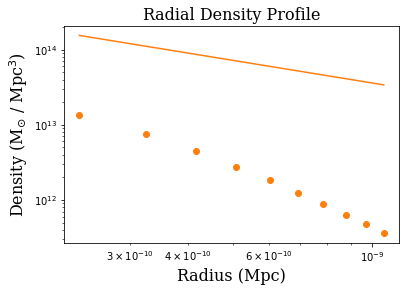

818466140441199.0 4.403497691074853e-11
3926605.361791262
3901312.70085997
3914430.9156788816
3889138.2547476273
3870666.2384557924
3857196.1515279654
3828645.89969465
3798260.0128522906
3747484.6049425397
3704543.2219090182
3621485.560988991
3541892.7416846906
3400983.5417104787
3273004.624551989
3036181.8645223314
2822373.9099877765
2431074.577587763
2064813.7206074162
1401695.4905722605
817486.7894745555
99246.36528081537
185380898.6867921
1493056.087263144
298025.8909848959
15367923000.252085
539880.3995752631
87325442.3274185
145009.3212513281
225024.69917958794
110485.04689771311
172403.41855973948
72068.37343999851
202016.07990893262
52397.88841081668
253144.56785613508
27082.472794843987
33783.47817240058
125624.34122479262
30937.162400967674
41881.56188453706
27695.634871124872
38966.02772946398
27502.058167627958
28234.12950765742
27086.373586050275
29098.15372837847
27006.643617101396
26943.961383548063
27027.62639456413
27440.922781005487
26954.567094630278
26925.2014011950

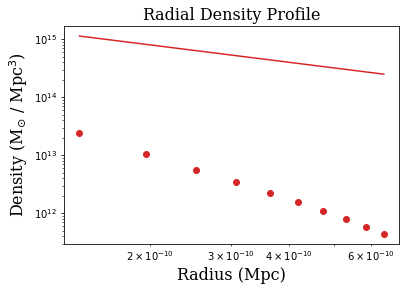

1.8296244099494544e+16 8.780697249012273e-12
2862868.387745868
2844754.1346427966
2854313.6134840804
2836199.3603810193
2823048.7527554417
2813241.84640844
2792753.167276789
2771231.015108374
2734997.4879406984
2704054.255392372
2644559.712039063
2587906.920723064
2487218.7189642387
2395388.8159776013
2225877.847465126
2073243.5415765601
1793390.3777843458
1531023.546951467
1056413.0613957185
638468.5445783879
25699.541163221882
94813831.16285574
1122087.6164901732
92921.11786692587
8630429158.711258
438972.6154714805
43762867.48063815
146671.52585239947
2690442.9985942254
37314.99799698332
80005.83472801662
40012.933477102204
27939.644398374807
219528.9887391244
17934.56838852063
18909.5506698129
38628.89135866599
17655.92290118195
18120.42912728845
17140.970963430293
22943.298705512225
16971.604354379044
17027.947928870708
18167.364087685663
16882.080716970853
17146.640164442106
16923.353853309352
16790.702960966824
16725.655683267127
16948.04651794293
16832.198048731567
16668.840587

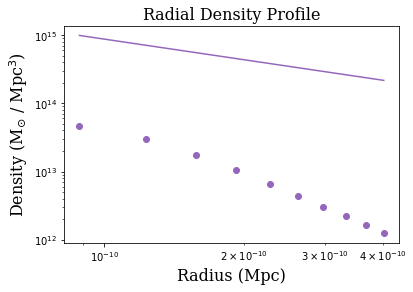

7561023236136592.0 1.1513629061453759e-11
3401289.2704384346
3379753.3973019915
3390289.3466603956
3368753.4735240117
3352722.345660939
3341867.8466975037
3317717.869180514
3290922.717743278
3247187.222091687
3211348.8976978795
3140665.6568419915
3071555.0209559132
2950707.4875601837
2842393.3896950665
2640374.228801398
2456476.7495694845
2121857.305311266
1810203.0351915795
1244446.317997773
744767.6396210908
22471.94657055701
77501528.80572942
1321365.681219821
94231.18298391372
5347243374.325537
508018.2648080342
37720862.41880143
162648.04297984968
2669276.8107134774
36100.71118049447
84438.15019379304
38856.88850710387
24696.411016013655
230086.89398099482
13977.244194640522
14962.305887864984
37439.36037801704
13581.341026993876
14039.858051489327
13008.687239059742
19409.812896889725
12851.366002304767
12972.683282371972
14283.343033847897
12747.006279866146
13019.512220375695
12822.035703173431
12664.120799155708
12593.033027254181
12798.234364654236
12699.30925190047
12532.293

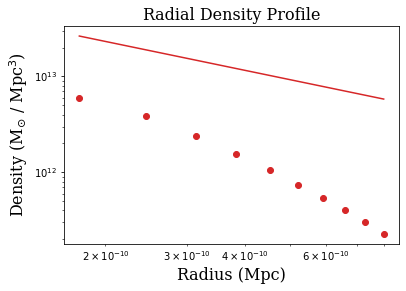

59021610799777.49 7.847331965588146e-11
5899139.824958943
5861164.395460177
5870827.521446833
5832852.092114011
5800319.176267035
5789834.084536828
5749494.179179273
5689257.665897635
5605058.568176574
5552081.918528307
5427972.28500367
5287200.911278854
5061818.734913643
4880107.013116806
4518606.377654485
4168092.81384394
3557447.312867167
3010861.2246962744
1997592.3027066176
1091753.565952065
161383.92383750444
45247708.177122116
2120457.5047679027
353206.7555966015
956134670.5254338
689304.5314722499
27713389.723431952
157488.99031857977
245547.71952626662
114495.46129341537
553347.1413274009
47171.422423231605
52814.95043302632
204443.30157776436
62363.23335452111
87302.29092862557
49505.389700241154
65058.3742764719
47436.1610339038
49895.40786262077
47589.05331187738
47701.11045704107
47109.00797806646
49128.377194148256
46989.94428082659
47140.89003933966
47030.366746978034
47301.736751985736
47011.28255068571
46958.89982796126
46947.00639895575
46896.117648332605
46859.711525

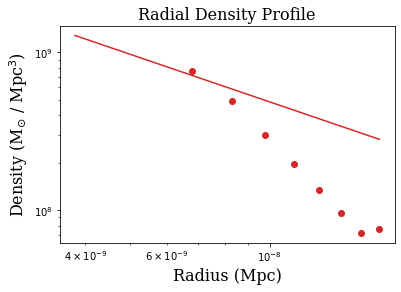

665716517.2681161 7.292642258822087e-09
17005829.746596664
16896851.389112353
16955884.422297757
16846906.0648135
16768516.466590017
16708040.833541196
16584394.260398123
16457127.636987489
16240344.359389147
16052446.16457217
15694426.786474615
15356807.036211893
14753128.44749724
14199094.446697833
13180179.888678623
12266322.96336624
10586116.956573643
9007186.367223566
6154553.681874959
3645578.8906625537
369094.3284494344
926733536.4966959
6551732.251645
1146298.9727150644
92467640516.94487
2446843.960609649
420959429.7337041
720721.4190123917
1079983.2310052728
565425.8892397005
642808.5929805855
183170.9503050935
5655781.948890576
189737.46944709617
308100.6594023051
190007.23694604868
182520.17901327243
369094.3284494344
765631.3685811479
137761.0788882182
137277.04116648616
153246.53045651608
189633.61314478167
145460.71462632227
153636.7438903008
138189.02116514608
142850.52706544922
137067.78905601302
136543.3094110324
136461.35827697493
138629.6973837737
136707.39541083798


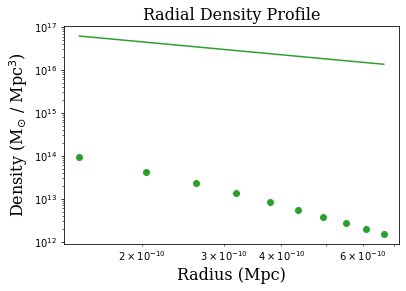

4.725583331956632e+18 1.909478276513614e-12
1941530.716170712
1929295.712070298
1935336.8971427917
1923101.8930424037
1914020.7780935117
1907800.2561381946
1894066.1494566712
1878924.0219776114
1854120.9071843212
1833696.8490173295
1793536.8453662796
1754391.0127924245
1685811.0022551864
1624217.8503486547
1509478.9731052876
1405164.8392455308
1215186.5786800785
1038110.9325182016
716790.4654214844
433077.34899181407
11342.32021847195
41149319.80012755
760566.7759512889
44147.895073741325
2913897304.8050666
298471.39268159406
19914097.730126943
101049.26160466523
1372215.2414976426
25973.39350953317
55374.61131233945
12182.090545816009
111156.3028914108
10665.257424485428
11503.47837856718
9383.236892126008
21194.646985152707
8710.74601515815
9466.627689394403
8781.110060125826
10506.992684099661
8788.867970236115
9300.86910946434
8695.4061973717
8657.134557415102
8687.626669916166
8783.487324586142
8674.913599955085
8624.155562917247
8589.256297301825
8582.434421844813
8566.3912326646

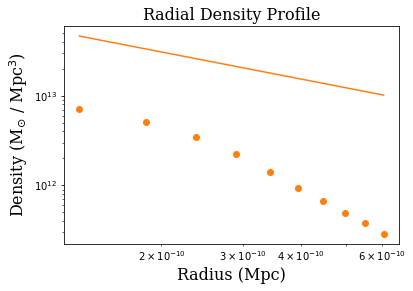

128062324608961.69 4.7839598777350516e-11
7547124.725587049
7499669.173955503
7523970.78365165
7476515.232020146
7441708.670075035
7416736.803172502
7363247.684604563
7305783.533643631
7210271.125065755
7130055.699009565
6974236.542068295
6824247.671764112
6559447.57825438
6319641.699012919
5875121.728265779
5473083.315580226
4738232.173512096
4051127.0751601737
2806413.977347291
1708911.2540523652
41412.4104310105
180644353.52930945
2977439.829928973
156639.467652848
14731764562.608608
1186207.9017516384
85058197.85685173
415907.0496374683
5408039.5571596315
114396.86075874824
235061.78575490616
43988.71447467441
404809.32576138794
47859.03348551053
139231.92293514428
35533.94509222837
36873.98771913537
49828.59002992401
36091.57292102219
36714.52239316621
35679.50842095875
35306.28686508924
36395.01796992485
38371.29752144908
35127.130927361504
34797.27148268446
34617.09565591412
35666.11547262565
34940.40900330899
34317.96718573845
33916.865829029724
33543.46301651228
32808.64174095

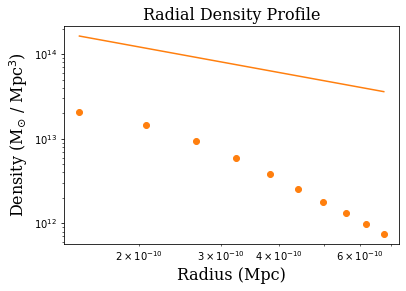

556736526089586.6 4.37593511139525e-11
3847124.879615602
3823332.317772584
3835049.5474772793
3811256.9856342818
3793583.4489592495
3781515.8681558026
3754815.8668858483
3725326.451705211
3677071.284215972
3637386.547261051
3559291.9275243455
3483109.2898616088
3349713.3629146093
3229962.1122957985
3006823.094149058
2803912.088109149
2434445.888976558
2090102.130160874
1465235.1033985545
913375.4680241735
9825.43219900925
51567589.17317337
1550365.0077570255
12640.346489580354
3910632193.212241
650976.5662715485
24509251.752697658
258426.50316160088
1477322.2717384596
89579.69568859726
216212.7917763606
29226.718519785558
47182.92771388862
10939.242663945171
50581.717894124
4557.796463490036
4783.04533212471
13635.448695086794
5715.378314072061
7110.636960100288
4775.143304932207
4985.019960732135
4621.322176587524
4950.802665545203
4615.977835078494
4558.296371714986
4490.979347678996
4463.546845894765
4659.787066112285
4509.960655249422
4392.451942786037
4303.5901970834
4246.89884730

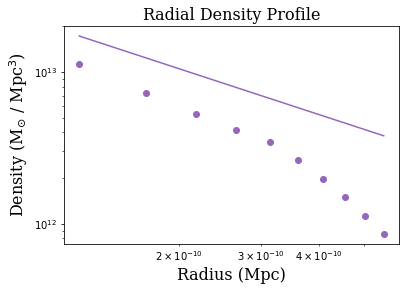

9420451308594.531 2.2314458289315963e-10
4184085.4625292667
4157867.7353761224
4171118.3582881717
4144900.6311350525
4125587.3993134056
4111961.1638810453
4082454.2256592573
4050452.0470606443
3997545.8234651024
3953429.439508318
3867354.566640879
3784120.524207284
3637587.6583760236
3505282.8298891983
3259596.740346926
3036975.8393800003
2630599.8200267567
2251051.268925387
1563077.4519223135
956138.8112617461
15756.834574452561
86009341.65624103
1657328.1864061086
62890.802693226826
6781701359.215494
667292.4879372898
40725352.863663614
240045.92264102102
2589596.534219808
68581.53935635123
461515.71760061325
20489.703645729984
62657.84620956949
31345.338205203432
22751.560853110415
15815.703214686722
35510.1128305836
15588.26795702899
15956.42072288245
15202.348540611263
16109.79030769638
15139.722784184645
17689.80622752594
15030.832122601458
15164.162869368458
15049.919437565644
15416.084738566868
15028.622781630485
14984.624962227681
14970.903741109141
15134.361783147364
14994.93

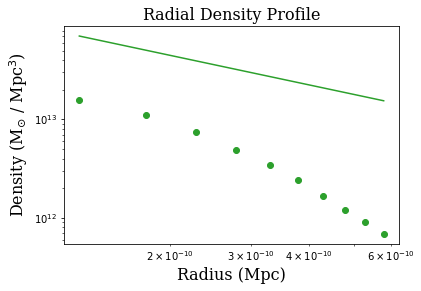

141304951381013.56 6.348518537276293e-11
5996922.515515671
5958895.8002525
5978881.648586034
5940854.933322888
5913208.950376156
5892701.345068399
5849710.73423801
5804410.266476739
5728280.988386856
5663417.046669641
5538526.799676133
5419422.786258889
5207937.412347762
5015247.495772962
4659349.409697166
4338685.71648813
3751007.1658572834
3200255.5086939945
2203769.6699718866
1326128.8606888813
58900.59786344132
205045829.84083265
2341521.1671092147
214376.3514052282
18348155050.400597
907473.6979402194
94981587.38679165
295704.0097748428
5925797.779098007
71386.20867644213
157750.56533136824
76720.41607993137
64404.55388136925
498592.22692041856
35382.59379028877
36918.02410217427
73981.05062244466
37828.52068582563
49275.12619659846
34844.862056202546
34890.15561965978
38584.74869916261
34591.674818096915
35470.94001753669
34647.80865816695
34267.932800708964
34073.644908121685
34822.27950781626
34389.52981655132
33807.68708055889
33403.71648763293
33129.44937297309
32794.81101351

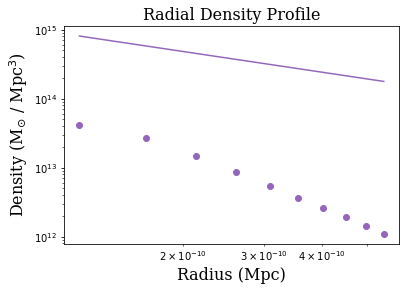

6035753447451257.0 1.5971065838970293e-11
10750522.047266934
10681686.378879664
10718429.345909558
10649593.677522335
10599818.738166342
10562148.457813634
10484184.927729908
10403003.997633548
10265641.759231023
10147580.70751807
9921471.831174413
9707062.03168608
9325002.63999431
8975615.372772014
8331701.645227017
7752872.073039404
6690328.422810405
5693182.244722727
3890347.639617081
2303717.0798027283
212450.72590835244
520086100.86890715
4140462.9443542077
670635.987880598
48699532479.32089
1546741.4992365013
239140155.8217333
456238.55127868924
682679.0137466163
119766.57213858128
5351375.025975993
137897.4554055222
201847.8900381882
120541.15570760341
142958.21419782
97291.59761480037
166287.64282761983
88268.11329894293
215694.07117750906
80672.66597315538
85458.57969682997
130090.12163018218
79805.66290579543
83392.93181504027
80276.43071521181
86007.21400504633
79469.98295983352
79470.35937995625
80884.10428979665
79416.30317641693
79681.21860286116
79399.86569177182
79327.3

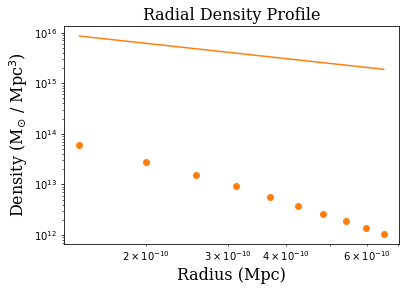

2.6356706913400915e+17 4.66106189773839e-12
2886671.5281727714
2868383.361142686
2877630.946456796
2859342.779426741
2845872.8126723464
2836363.6711023096
2815779.933303362
2793463.0774923116
2756561.1211165846
2725783.6113194185
2665741.870459037
2607688.9262578553
2505477.4153580787
2413186.5414909767
2241809.371642998
2086520.3516101716
1803045.9039535704
1538293.4036721766
1058390.3717433256
635068.5135744251
27565.345911416334
78317688.40221457
1124122.9558027284
96783.00372037482
5945367262.818575
433931.1187549184
37441440.37557264
140758.75138408729
2542660.5928235156
34337.170721028655
74896.93268707723
36730.07582187446
29874.493781212987
224188.56026195543
17168.501061535964
17894.00336412267
35500.32997230417
18105.831166643453
23811.261707048296
16831.810742684807
16789.169157968186
17793.84434033233
18404.120239548793
16745.152740881662
16483.67203045931
16293.897248767125
16738.491632377652
16117.692831954613
15896.751531594822
15369.824559637362
14717.395478611368
15585

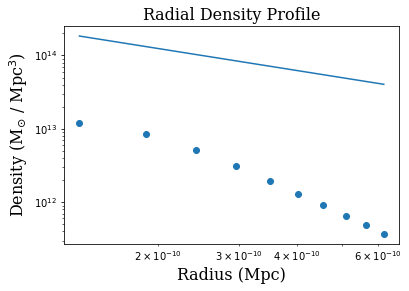

1056567456773508.1 2.3599231290218906e-11
2214300.8879630025
2200972.008376573
2207246.701498914
2193917.821912501
2183878.530977292
2177399.0141364937
2162514.2458331585
2145572.4511676827
2118309.8321114806
2096409.3587035472
2052677.0123179676
2009385.7402950027
1934258.0869519429
1867472.4809373107
1742296.7481402738
1627775.629475769
1420132.2413052453
1227321.2579370844
876738.8012905752
566532.9333766757
30036.69107999814
12784320.991756897
924025.9572532943
7563.90440538507
12784320.991756853
849107988.1817122
419386.1352100634
6165772.788104539
196486.20530058892
323650.86496404273
93945.06430930145
25524.587876517948
100469.27205962682
8577.61282406966
56801.52108417903
4162.262011156428
4676.102309176757
27050.030616967168
3485.3213140719754
3863.736276478521
8049.981519168319
3222.2971674701253
3293.3425348572937
4408.497807412354
3199.7322280850312
3388.6516216940995
3204.7785170192146
3153.987912817378
3169.047733333803
3344.4782885015034
3165.5101134771903
3134.115851421

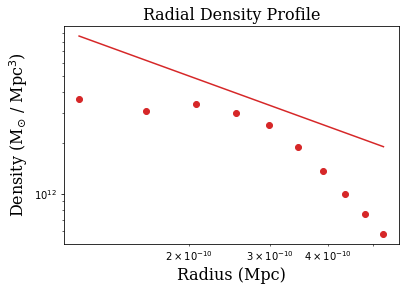

3313256653576.134 3.0217518416267944e-10
3534107.2798351534
3511763.5742405364
3523188.277786618
3500844.5721920263
3484448.0610310375
3472707.4004730247
3447527.240097178
3420445.706011636
3375461.063401869
3337713.2047863277
3264349.2313380823
3193691.443317504
3068989.079798163
2956099.4604705134
2746793.301036327
2557443.8158948487
2211404.317507471
1887898.3701534139
1301807.9978770416
785029.8579221555
27212.481016703274
96311363.07378414
1382301.929684293
102413.53320387162
7730122636.999909
539108.5500383287
45533556.0840735
179069.0857524729
2977115.9006427308
44494.00041041124
96822.62563912904
47688.30971979303
29554.053182000887
246545.69882384725
19838.90707440478
21087.672836307782
46048.67110266911
18690.02372166296
19054.72606028554
28363.240309400295
18189.250162110176
18741.626205583165
18322.196736386555
19346.819955242536
18272.665649230912
18096.330950887936
18076.886146741323
17871.22352920877
17767.248295160018
17506.597509218474
17220.93722193893
16903.376666103

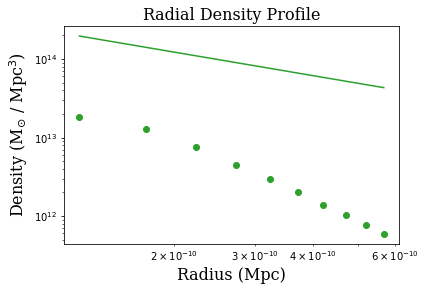

888368462694640.0 2.7687651339258665e-11
6555191.568710066
6512998.72356946
6535982.788601551
6493789.943460964
6463501.249150323
6439962.718380968
6392058.465014238
6342971.593272382
6259141.294160442
6186247.200778653
6047626.23894225
5917180.515418654
5683629.306599003
5468994.651940163
5074578.735678916
4721129.265781127
4070890.3257271964
3459540.379715199
2355315.309414839
1384399.0619118072
191359.81867866544
418341244.38435733
2509256.343571914
559241.1401364323
42363467843.162636
920606.6754432606
189576567.10239542
258423.52387365658
394659.8104614235
200648.5769146925
323129.4562825039
135129.81482099884
379823.96736337285
101905.2468492041
441080.4159532514
59772.56200781556
72328.77033016054
239122.40194884234
65682.77171883355
83960.74587414475
61006.42934122984
81882.57219653513
60117.60032450271
61220.19827050314
59758.788311801974
63719.3994771238
59435.484830486486
59543.59532649439
60224.54913790441
59493.54068544523
59448.426753192405
59339.23604905256
59304.2543956

131.91616153666473
131.70047643579892
131.79467047202343
131.19518807094573
130.97004918994935
131.39404443007516
130.49633165127307
132.58227269312192
134.47012344348695
130.78731845310904
130.29335603633808
130.24379881607456
129.9927882492193
132.06576279959336
129.49660063300325
129.2876209055903
130.42686774438334
129.74452433901388
131.43738693598425
129.46943792926686
128.87164660330382
128.85008360682332
128.32490188552765
129.61177103624868
133.23877275769337
128.69118036671352
128.48458996344925
127.96971268751804
128.504435760271
129.57280653408452
128.15806318850446
127.84191432803345
127.77564932703172
127.48874432199227
127.81882234879595
127.31560712659484
127.15692292283347
127.04793887723281
129.31743363526766
126.3667428547451
126.66748618184647
128.97680667755776
126.72918632081564
126.60173361496709
125.96791748468968
125.97175808714383
126.72947547082367
126.27907911681541
125.99319294645466
125.65739012794802
125.77970464082318
125.99653260359992
125.8544879228175

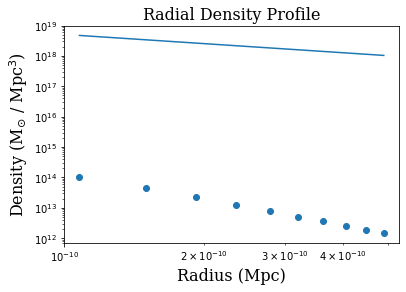

4.042005548741691e+21 1.2621929234358047e-13
573388.9770225132
570068.5647236718
570493.1482532091
567172.7359832991
564127.2296766412
563618.4138247609
560197.1134752012
554318.1645196964
546622.8699426289
542472.0977874678
531645.4547054495
518447.1726572192
498164.24106155575
482711.6483063776
450856.276032849
418983.7258694094
364639.972061939
316984.47745193366
227645.39171702272
146935.49332419178
41759.283056165565
1854895.2446912457
237819.16847805274
46950.227632558584
32557358.50863204
111424.64765934482
1177727.9089782746
61077.710408731924
192166.24705199272
44509.05985321077
49773.084591391926
41897.66349649443
57875.57268595613
41512.47008711079
41418.92189499999
42534.670022050675
44459.81185285729
41131.26268972969
41021.63212265818
41090.40912156987
41685.212901476014
41137.472016728454
41251.63699069957
41077.99787737299
40981.765260623084
40949.187802330656
40856.127716766416
40760.56502318395
40833.714138044845
40646.11853458604
40587.68699519463
40466.12172934154
4

38133.71574413475
38133.71345284869
38133.71118723671
38133.708792145975
38133.708724603224
38133.7544031008
38133.695225469266
38133.69123169544
38133.766878395305
38133.69913108621
38133.68589198148
38133.68885911863
38133.689934730915
38133.677499943784
38133.67597876741
38133.71268095724
38133.679002423036
38133.6732943805
38133.72898051918
38133.66637290969
38133.688242912656
38133.7311860973
38133.66800816939
38133.66196580902
38133.66363271244
38133.659613659016
38133.66612712449
38133.65862902872
38133.66205396265
38133.65717112298
38133.66909113229
38133.650139941514
38133.657807142656
38133.65420983276
38133.64664295732
38133.65036263695
38133.67309558038
38133.64758740455
38133.64764838902
38133.644595851336
38133.64637119487
38133.64705951534
38133.645772661446
38133.648111249815
38133.64802299351
38133.64473388196
38133.64483664764
38133.64501086414
38133.6442236422
38133.647415901134
38133.64241513345
38133.644987525535
38133.64922296991
38133.6458549885
38133.6456303993


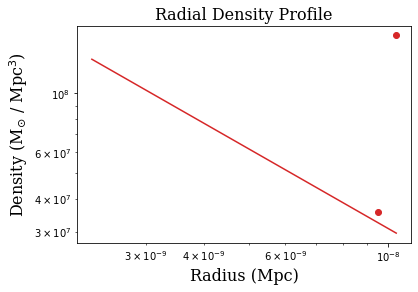

1457.805476230531 0.0002119187232218663
4007571.074772647
3983287.3565315474
3994851.1340680122
3970567.4158269414
3952339.992077131
3940407.033587186
3913255.414262011
3882581.447242326
3833016.4351797868
3792965.423958829
3713282.176858629
3634689.047651436
3497995.169757959
3376183.152880118
3148204.384911248
2939942.660881144
2561937.45498082
2210615.2966105426
1572127.4121528037
1007430.1811792855
40952.36281008921
28142986.954528123
1658458.177092084
8230.565785601233
28142986.954528365
1912286021.9668334
739407.3264956
13557801.881284699
334478.47005808656
749432.5623704644
150570.79606904954
73335.94149388863
8428.888813562502
61211.007294606694
15784.519371602937
17929.044973747397
8582.543439858211
8680.062830672645
6631.448578008165
19527.053335241882
5959.450260159827
6798.633912825642
6040.048905008611
7668.491479124127
6041.852461961137
6527.8690691622105
5949.325792450998
5940.4205147878765
6031.245278580764
6063.419075819416
5932.92781622901
5906.811859347325
5886.54353

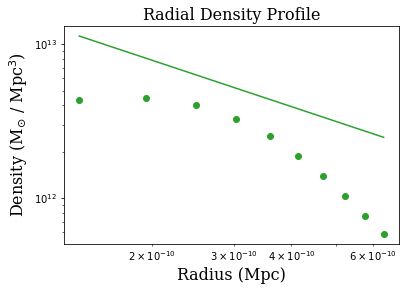

5689658852001.595 2.7643028513476114e-10
2137811.105566821
2124653.753085661
2131693.5741867996
2118536.221705641
2109030.6289893407
2101813.4197780914
2086907.184107294
2071415.4247087892
2045174.8547741303
2022587.0535515924
1979367.2055270926
1938425.676173406
1865429.022328108
1798623.0622876901
1675557.552170914
1564994.844693299
1361971.8575404664
1171364.5412342218
826830.6633430548
523586.11978937825
10597.430445732269
37059334.394507654
874697.1385635141
5099.217082145996
37059334.39450788
3962011374.912128
378269.3615933509
16481376.782098688
159791.2848387817
814162.2510243445
62175.76363278312
102592.8798162607
24477.039673914773
18976.720647508097
5706.753449091888
42036.14672416881
4277.190265979857
4526.008985051669
10987.648638442557
3682.6640542258656
3842.7642698933446
5397.043153906776
3766.2484124992984
3836.859257514454
3720.4068125131434
3639.0145430532466
3696.377959192793
3940.483834873403
3649.6988832990346
3605.5002379617376
3598.150829351309
3541.416196111245

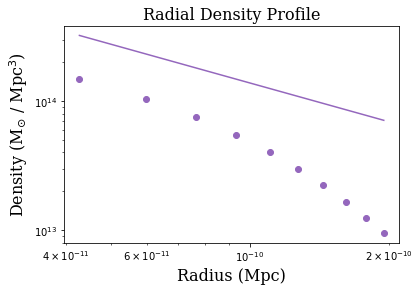

282798776478691.3 4.885343195436829e-11
4953804.552423379
4921831.986671568
4938125.939695025
4906153.37394329
4882664.545613397
4865917.514510314
4829899.740275528
4791067.821867834
4726652.660307762
4672701.899355741
4567725.530160621
4466498.051469818
4287974.257177306
4126497.799706924
3826957.6044760733
3555825.782722564
3060507.2732743034
2597611.8179913363
1758830.4110823495
1019401.4280115488
141668.96210270323
222044075.79448032
1873902.7561474426
406944.3366941791
16996696280.498894
668920.4458944931
106250865.77248989
173962.75938715032
272875.3161022739
131484.52290679514
241266.0576307659
85200.02785162775
421684.27287444577
36152.80774858758
47141.1604015448
201377.69690195352
45499.64605569826
75044.44503376562
36248.43042852463
49493.27921597218
38235.59129949583
39289.80353641225
36392.272060198295
36802.13443940013
35961.80061314031
38024.5434876341
35865.61896951187
35845.62385181249
36112.14330916027
36312.11781899571
35836.35383626529
35760.09133197789
35708.581574

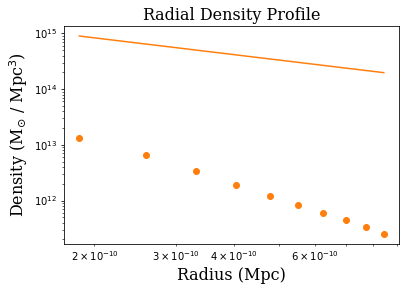

1.7626636876265236e+16 9.461992429029969e-12
4970940.730334352
4939717.6270514
4955818.657510613
4924595.554227685
4901748.348143241
4885209.548941921
4849988.512279392
4812343.418779917
4749590.562386736
4696684.84493098
4594157.879863594
4495711.279097648
4321642.293800657
4163746.487621524
3871343.513512741
3607155.5383434985
3123924.834112317
2671810.8916371954
1853064.2970832607
1131346.858706595
26486.72100985831
120092295.90081656
1965749.5015612834
97743.52743248324
10087040198.777168
787343.2644336508
56217182.69626087
279633.685197783
3507126.0128049734
78959.8370813414
159805.3045237579
27923.686062876506
255599.3430839581
33346.08545964287
86673.35542849795
23997.586322631796
25116.096887552
34745.650794992536
23770.055169429397
23936.90513124031
27167.250610360366
23489.92997234933
24073.37916347051
23656.297326710246
23272.01991355193
23098.716960259004
23591.94991380389
23361.68579306421
23036.900855676548
23011.014734091565
22573.908778953013
22307.74193736939
23891.788

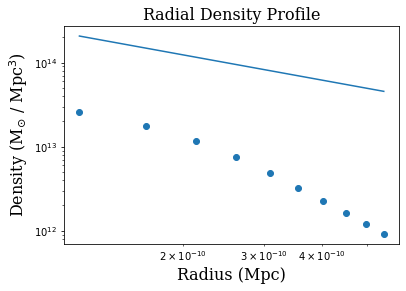

707072777270485.6 3.501147776727402e-11
3798442.4940439044
3774587.0544015607
3787739.7852711007
3763884.345628758
3746835.463720126
3733373.0325884754
3706248.7408092385
3678726.4960253756
3631457.158283749
3590059.771959338
3511675.3123528813
3438264.237838412
3306443.6734310305
3184919.2220384856
2962017.482593798
2762677.5953852613
2395445.31864461
2049734.7704394832
1425742.153035645
877270.3973758484
18943.255999256413
135001024.05490318
1513044.5553061399
74579.49107454577
15647328531.763554
614053.3473232667
59396121.22920734
223686.98272017945
3123433.034462711
64782.55444029116
130439.99991893386
20010.110669652226
201511.5460007587
26855.250536051346
64798.08449120205
18221.797554663037
19407.671442555147
17903.815374750815
24190.04378290091
17507.225309494737
17868.61982401387
19424.38225375517
17549.112551086175
17579.27231173157
17483.753934685006
17392.5736307204
17362.42065222015
17293.35195736141
17280.428839923334
17021.520968809455
16826.592560285113
16789.7074136983

KeyboardInterrupt: 

In [7]:
c = []
r200 = []
M200 = []

for j in largest_halos:
    radial_fractions, density, radial_counts, radius, std_density = get_density_profile(particle_data, ascii_data,
                                                                                       halo_breaks, j, 10)
    Rs_opt, rho_0_opt = fit_profile_to_nfw(radial_fractions, density, radial_counts)
    
    r200.append(radius)
    c.append(Rs_opt / radius)
    M200.append(get_mass(radius, Rs_opt, rho_0_opt))
    radial_fit = np.linspace(np.min(radial_fractions), np.max(radial_fractions), 1000)
    nfw_fit = model_nfw(radial_fit, Rs_opt, rho_0_opt)
    
    plt.plot(radial_fit, nfw_fit, '-', color=colors[j%5])
    plt.plot(radial_fractions, density, 'o', color=colors[j%5])
    plt.xlabel('Radius (Mpc)', fontsize=16, fontname='serif')
    plt.ylabel(r'Density (M$_{\odot}$ / Mpc$^3$)', fontsize=16, fontname='serif')
    plt.title(r'Radial Density Profile',
              fontsize=16, fontname='serif')
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
    
    print(Rs_opt, rho_0_opt)